<a href="https://colab.research.google.com/github/HoCogThanh/thanh/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Xử lý file và hình ảnh
import os
import cv2
import random

# Xử lý dữ liệu và toán học
import numpy as np
from collections import Counter
from statistics import mean, stdev

# Trích xuất đặc trưng
from skimage.feature import hog
from skimage import exposure

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

'/content/drive/MyDrive/DATASET/Lua' là một thư mục hợp lệ.

Tổng số lượng ảnh trong toàn bộ dữ liệu: 8736


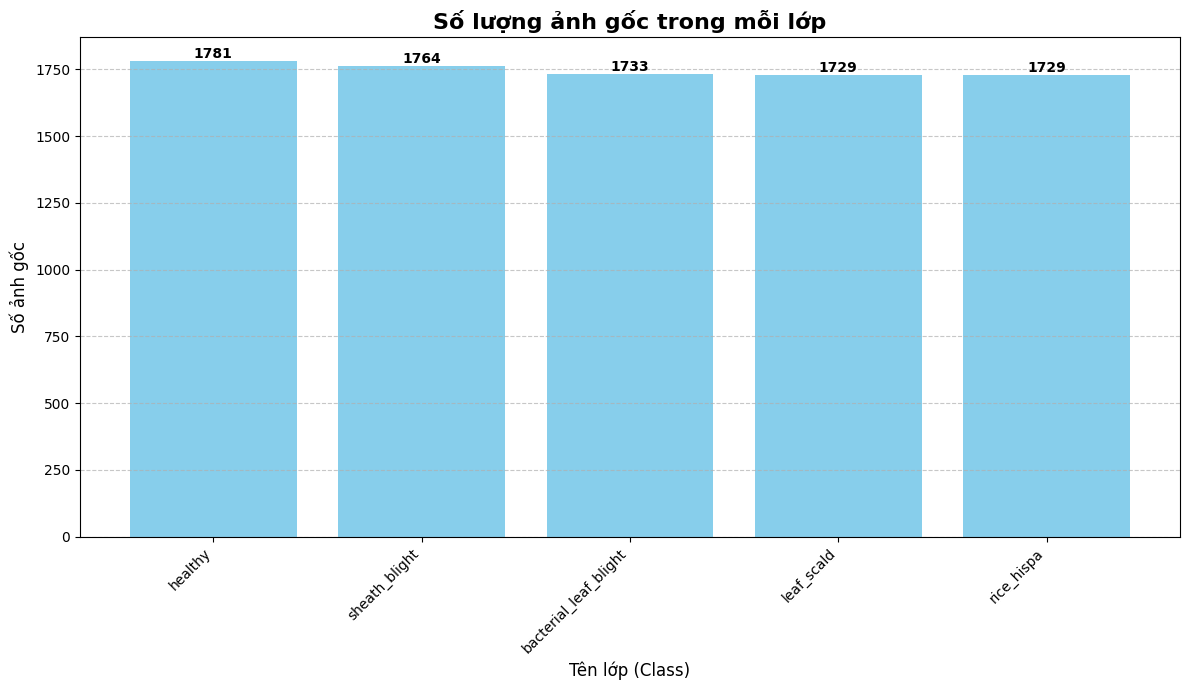

In [ ]:
#Thống kê dữ liệu

data_dir = "/content/drive/MyDrive/DATASET/Lua"

if not os.path.isdir(data_dir):
    print(f"Lỗi: '{data_dir}' không phải là một thư mục hợp lệ hoặc không tồn tại.")
    # Có thể exit() hoặc return ở đây nếu muốn dừng chương trình
else:
    print(f"'{data_dir}' là một thư mục hợp lệ.")

    # Lấy danh sách các lớp (thư mục con)
    categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    if not categories:
        print(f"Không tìm thấy thư mục lớp nào trong '{data_dir}'.")
    else:
        # Thống kê số lượng ảnh trong mỗi lớp
        original_counts = {}
        supported_extensions = ('.png', '.jpg', '.jpeg')

        for category in categories:
            class_path = os.path.join(data_dir, category)
            # Lọc các file có phần mở rộng ảnh hợp lệ
            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(supported_extensions) and os.path.isfile(os.path.join(class_path, f))]
            original_counts[category] = len(image_files)

        # --- In ra tổng số ảnh ---
        total_images = sum(original_counts.values())
        print(f"\nTổng số lượng ảnh trong toàn bộ dữ liệu: {total_images}")

        # --- Vẽ biểu đồ số lượng ảnh gốc ---
        plt.figure(figsize=(12, 7)) # Tăng kích thước biểu đồ để dễ nhìn hơn

        # Sắp xếp các lớp theo số lượng ảnh để biểu đồ dễ đọc hơn (tùy chọn)
        sorted_counts = dict(sorted(original_counts.items(), key=lambda item: item[1], reverse=True))

        bars = plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue') # Đổi màu cho dễ nhìn

        plt.title("Số lượng ảnh gốc trong mỗi lớp", fontsize=16, fontweight='bold')
        plt.xlabel("Tên lớp (Class)", fontsize=12)
        plt.ylabel("Số ảnh gốc", fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10) # Xoay nhãn và căn chỉnh
        plt.yticks(fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Ghi số lượng lên cột
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height, str(height), # Đặt text ngay trên cột
                     ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

        plt.tight_layout() # Tự động điều chỉnh bố cục để tránh chồng lấn
        plt.show()

Tổng số mẫu GỐC: 8736

Chia tập dữ liệu gốc 80-10-10:
   Train_raw: 6988
   Val_raw:   874
   Test_raw:  874

Đang thực hiện augment và trích xuất đặc trưng cho tập huấn luyện...
Tổng số mẫu Train sau khi augment và trích xuất đặc trưng: 34940
Hiển thị ảnh mẫu đã tăng cường:


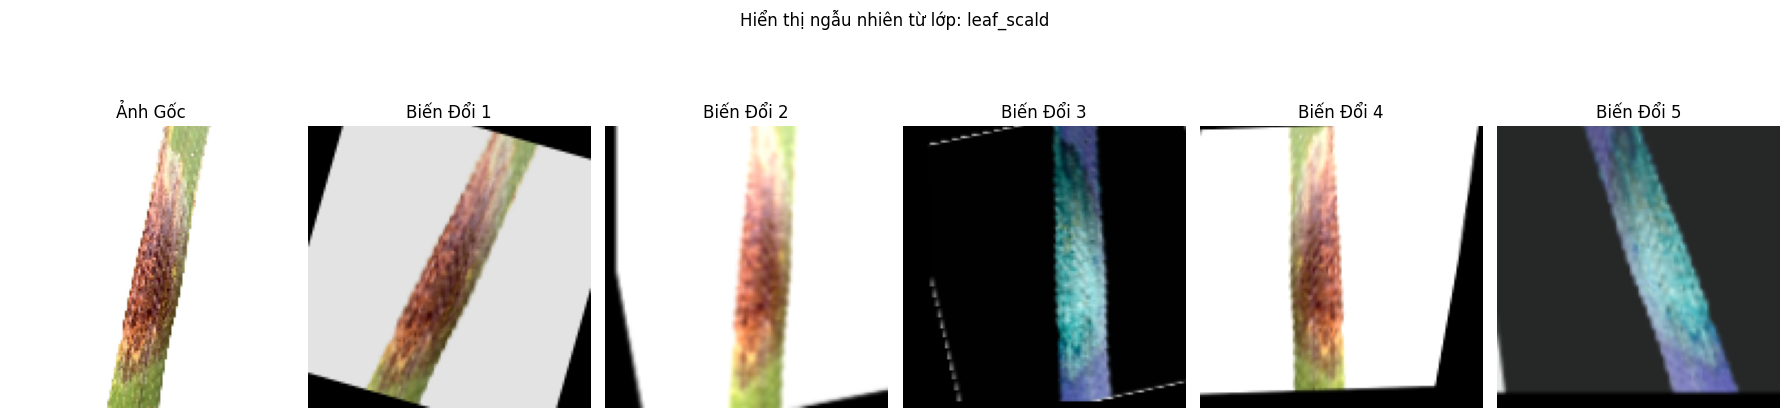


Đang trích xuất đặc trưng cho tập Validation...

Đang trích xuất đặc trưng cho tập Test...

Đang chuẩn hóa dữ liệu - MinMaxScaler

Đã fit transform trên tập train

Đã transform trên tập val/test

✅ Đã lưu scaler/train/val/test lần 1 thành công!


In [ ]:
#HOG kết hợp với Histogram Color

data_dir = "/content/drive/MyDrive/DATASET/Lua"
dest_dir = "/content/drive/MyDrive/Lua_16:4_HOG+Color"
os.makedirs(dest_dir, exist_ok=True)

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

def rotate_image(img):
    angle = random.randint(-20, 20)
    (h, w) = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
    return cv2.warpAffine(img, M, (w, h))

def flip_image(img):
    return cv2.flip(img, 1)

def shear_image(img):
    shear = random.uniform(-0.2, 0.2)
    M = np.array([[1, shear, 0], [0, 1, 0]], dtype=np.float32)
    (h, w) = img.shape[:2]
    return cv2.warpAffine(img, M, (w, h))

def adjust_brightness(img):
    factor = random.uniform(0.7, 1.3)
    return np.clip(img * factor, 0, 255).astype(np.uint8)

def zoom_image(img, zoom_range=(0.8, 1.2)):
    h, w = img.shape[:2]
    zoom_factor = random.uniform(zoom_range[0], zoom_range[1])

    # Kích thước mới của ảnh sau khi zoom
    new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)

    if zoom_factor >= 1.0:
        crop_h, crop_w = int(h / zoom_factor), int(w / zoom_factor)
        crop_h = max(1, crop_h)
        crop_w = max(1, crop_w)

        start_x = random.randint(0, w - crop_w)
        start_y = random.randint(0, h - crop_h)

        cropped_img = img[start_y:start_y+crop_h, start_x:start_x+crop_w]
        return cv2.resize(cropped_img, (w, h), interpolation=cv2.INTER_LINEAR)
    else:
        resized_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        canvas = np.zeros((h, w, 3), dtype=img.dtype)

        start_x = (w - new_w) // 2
        start_y = (h - new_h) // 2

        # Đảm bảo chỉ số không âm
        start_x = max(0, start_x)
        start_y = max(0, start_y)

        # Đặt ảnh đã thu nhỏ vào canvas
        canvas[start_y : start_y + new_h, start_x : start_x + new_w] = resized_img
        return canvas


def translate_image(img, translation_range=(-0.1, 0.1)):
    h, w = img.shape[:2]
    tx = random.uniform(translation_range[0], translation_range[1]) * w
    ty = random.uniform(translation_range[0], translation_range[1]) * h
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(img, M, (w, h))

def color_jitter(img, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1):
    img = img.astype(np.float32) / 255.0 # Chuyển sang float [0, 1]

    # Brightness
    img = np.clip(img * random.uniform(1 - brightness, 1 + brightness), 0, 1)

    # Contrast
    mean = img.mean(axis=(0,1), keepdims=True)
    img = np.clip((img - mean) * random.uniform(1 - contrast, 1 + contrast) + mean, 0, 1)

    # Convert to HSV for Saturation and Hue
    img_hsv = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2HSV)
    img_hsv = img_hsv.astype(np.float32)

    # Saturation
    img_hsv[:,:,1] = np.clip(img_hsv[:,:,1] * random.uniform(1 - saturation, 1 + saturation), 0, 255)

    # Hue
    img_hsv[:,:,0] = np.clip(img_hsv[:,:,0] + random.uniform(-hue, hue) * 180, 0, 180) # Hue range 0-180 in OpenCV

    img = cv2.cvtColor(img_hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

    return (img * 255).astype(np.uint8)

def random_cropping(img, min_crop_ratio=0.8):
    h, w = img.shape[:2]

    # Kích thước cắt tối thiểu
    min_crop_h = int(h * min_crop_ratio)
    min_crop_w = int(w * min_crop_ratio)

    # Chọn kích thước ngẫu nhiên cho phần cắt
    crop_h = random.randint(min_crop_h, h)
    crop_w = random.randint(min_crop_w, w)

    # Chọn tọa độ bắt đầu ngẫu nhiên
    start_x = random.randint(0, w - crop_w)
    start_y = random.randint(0, h - crop_h)

    cropped_img = img[start_y:start_y + crop_h, start_x:start_x + crop_w]
    return cv2.resize(cropped_img, (w, h)) # Resize lại về kích thước ban đầu

def augment_image(img, n_augments=4):
    images = [img]
    for _ in range(n_augments):
        aug_img = img.copy()


        transformations = [
            rotate_image,
            flip_image,
            shear_image,
            adjust_brightness,
            zoom_image,
            translate_image,
            color_jitter,
            random_cropping
        ]
        random.shuffle(transformations) # Xáo trộn thứ tự biến đổi

        # Áp dụng một số biến đổi ngẫu nhiên
        num_transforms_to_apply = random.randint(1, len(transformations))
        for t_func in transformations[:num_transforms_to_apply]:
            aug_img = t_func(aug_img)

        images.append(aug_img)
    return images

# --- Hàm mới để trích xuất histogram màu ---
def extract_color_histogram(image, bins=(8, 8, 8)):
    # Chuyển đổi ảnh sang không gian màu HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Tính toán histogram cho từng kênh màu H, S, V
    hist_h = cv2.calcHist([hsv_image], [0], None, [bins[0]], [0, 180])
    hist_s = cv2.calcHist([hsv_image], [1], None, [bins[1]], [0, 256])
    hist_v = cv2.calcHist([hsv_image], [2], None, [bins[2]], [0, 256])

    # Chuẩn hóa và nối các histogram lại
    hist_h = cv2.normalize(hist_h, hist_h).flatten()
    hist_s = cv2.normalize(hist_s, hist_s).flatten()
    hist_v = cv2.normalize(hist_v, hist_v).flatten()

    # Kết hợp các histogram lại thành một vector đặc trưng duy nhất
    return np.concatenate((hist_h, hist_s, hist_v))


####
X_original, y_original = [], []

for idx, category in enumerate(categories):
    class_path = os.path.join(data_dir, category)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (128, 128))
        X_original.append(img)
        y_original.append(idx)

X_original = np.array(X_original)
y_original = np.array(y_original)
print(f"Tổng số mẫu GỐC: {X_original.shape[0]}")

X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(
    X_original, y_original, test_size=0.2, stratify=y_original, random_state=None
)
X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(
    X_temp_raw, y_temp_raw, test_size=0.5, stratify=y_temp_raw, random_state=None
)

print(f"\nChia tập dữ liệu gốc 80-10-10:")
print(f"   Train_raw: {len(X_train_raw)}")
print(f"   Val_raw:   {len(X_val_raw)}")
print(f"   Test_raw:  {len(X_test_raw)}")

X_train_augmented, y_train_augmented = [], []

print("\nĐang thực hiện augment và trích xuất đặc trưng cho tập huấn luyện...")
for i, img in enumerate(X_train_raw):
    augmented_images = augment_image(img, n_augments=4) # Áp dụng augment ở đây
    for aug_img in augmented_images:
        gray = cv2.cvtColor(aug_img, cv2.COLOR_BGR2GRAY)

        # Trích xuất HOG
        hog_features = hog(
            gray,
            pixels_per_cell=(16, 16),
            cells_per_block=(4, 4),
            block_norm='L1-sqrt',
            feature_vector=True,
            visualize=False
        )

        # Trích xuất Histogram màu
        color_hist_features = extract_color_histogram(aug_img)

        # Kết hợp các đặc trưng
        combined_features = np.concatenate((hog_features, color_hist_features))

        X_train_augmented.append(combined_features)
        y_train_augmented.append(y_train_raw[i]) # y_train_raw[i] là nhãn của ảnh gốc

X_train_final = np.array(X_train_augmented)
y_train_final = np.array(y_train_augmented)
print(f"Tổng số mẫu Train sau khi augment và trích xuất đặc trưng: {X_train_final.shape[0]}")

print("Hiển thị ảnh mẫu đã tăng cường:")
random_category = random.choice(categories)
random_class_path = os.path.join(data_dir, random_category)
random_image_name = random.choice(os.listdir(random_class_path))
random_image_path = os.path.join(random_class_path, random_image_name)

sample_img = cv2.imread(random_image_path)
if sample_img is not None:
    sample_img = cv2.resize(sample_img, (128, 128))
    sample_augmented_images = augment_image(sample_img, n_augments=5) # Hiển thị thêm ảnh để thấy các biến đổi mới

    fig, axes = plt.subplots(1, 6, figsize=(18, 5)) # Cập nhật số lượng subplot
    axes[0].imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Ảnh Gốc")
    axes[0].axis('off')

    for i, aug_img in enumerate(sample_augmented_images[1:6]): # Cập nhật vòng lặp
        axes[i+1].imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
        axes[i+1].set_title(f"Biến Đổi {i+1}")
        axes[i+1].axis('off')

    plt.suptitle(f"Hiển thị ngẫu nhiên từ lớp: {random_category}")
    plt.tight_layout()
    plt.show()
else:
    print(f"Không thể tải ảnh mẫu từ: {random_image_path}")

X_val_features, y_val_features = [], []
print("\nĐang trích xuất đặc trưng cho tập Validation...")
for i, img in enumerate(X_val_raw):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_features = hog(
        gray, pixels_per_cell=(16, 16), cells_per_block=(4, 4),
        block_norm='L1-sqrt', feature_vector=True, visualize=False
    )
    color_hist_features = extract_color_histogram(img)
    combined_features = np.concatenate((hog_features, color_hist_features))
    X_val_features.append(combined_features)
    y_val_features.append(y_val_raw[i])
X_val_final = np.array(X_val_features)
y_val_final = np.array(y_val_features)

X_test_features, y_test_features = [], []
print("\nĐang trích xuất đặc trưng cho tập Test...")
for i, img in enumerate(X_test_raw):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_features = hog(
        gray, pixels_per_cell=(16, 16), cells_per_block=(4, 4),
        block_norm='L1-sqrt', feature_vector=True, visualize=False
    )
    color_hist_features = extract_color_histogram(img)
    combined_features = np.concatenate((hog_features, color_hist_features))
    X_test_features.append(combined_features)
    y_test_features.append(y_test_raw[i])
X_test_final = np.array(X_test_features)
y_test_final = np.array(y_test_features)

print("\nĐang chuẩn hóa dữ liệu - MinMaxScaler")
#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(X_train_final)

X_train_scaled = scaler.transform(X_train_final)
print('\nĐã fit transform trên tập train')
X_val_scaled = scaler.transform(X_val_final) # Transform val và test
X_test_scaled = scaler.transform(X_test_final)
print('\nĐã transform trên tập val/test')

train_round = 1
while (os.path.exists(os.path.join(dest_dir, f"X_train{train_round}.npy")) or
       os.path.exists(os.path.join(dest_dir, f"X_val{train_round}.npy")) or
       os.path.exists(os.path.join(dest_dir, f"X_test{train_round}.npy"))):
    train_round += 1

joblib.dump(scaler, os.path.join(dest_dir, f"scaler{train_round}.pkl"))
np.save(os.path.join(dest_dir, f"X_train{train_round}.npy"), X_train_scaled)
np.save(os.path.join(dest_dir, f"y_train{train_round}.npy"), y_train_final)
np.save(os.path.join(dest_dir, f"X_val{train_round}.npy"), X_val_scaled)
np.save(os.path.join(dest_dir, f"y_val{train_round}.npy"), y_val_final)
np.save(os.path.join(dest_dir, f"X_test{train_round}.npy"), X_test_scaled)
np.save(os.path.join(dest_dir, f"y_test{train_round}.npy"), y_test_final)
print(f"\n✅ Đã lưu scaler/train/val/test lần {train_round} thành công!")

Tổng số mẫu GỐC: 8736

Chia tập dữ liệu gốc 80-10-10:
   Train_raw: 6988
   Val_raw:   874
   Test_raw:  874

Đang thực hiện augment và trích xuất đặc trưng (Color Histogram) cho tập huấn luyện
Tổng số mẫu Train sau khi augment và trích xuất đặc trưng: 34940
Hiển thị ảnh mẫu đã tăng cường:


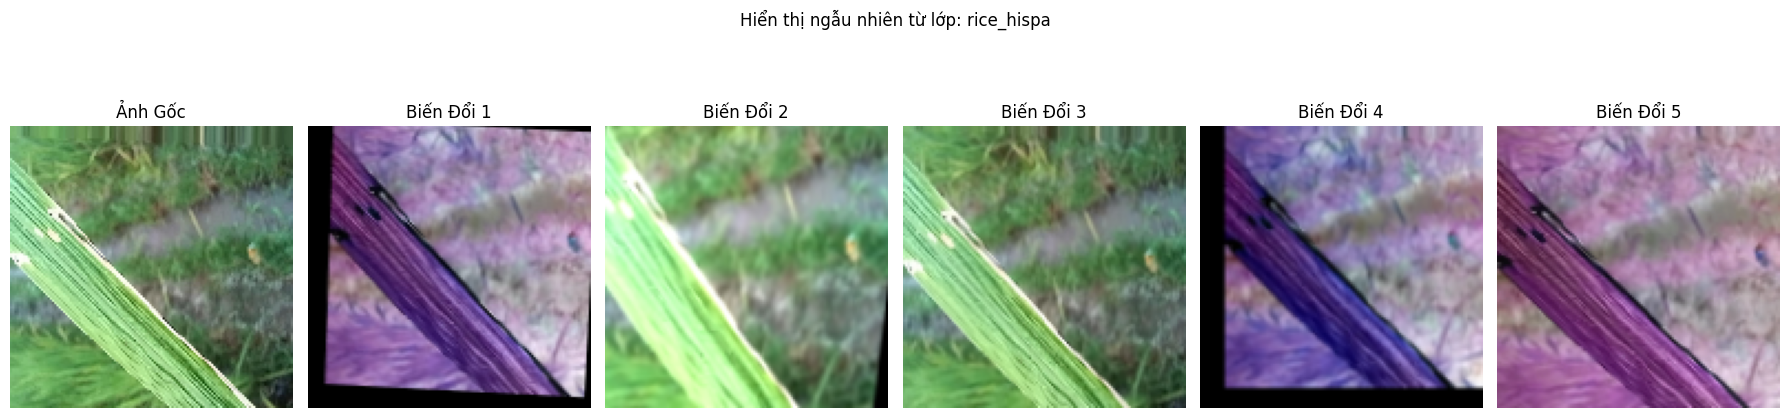


Đang trích xuất đặc trưng (Color Histogram) cho tập Validation

Đang trích xuất đặc trưng (Color Histogram) cho tập Test

Đang chuẩn hóa dữ liệu - MinMaxScaler

Đã fit transform trên tập train

Đã transform trên tập val/test

Đã lưu scaler/train/val/test lần 2 thành công!


In [ ]:
#Color histogram

data_dir = "/content/drive/MyDrive/DATASET/Lua"
dest_dir = "/content/drive/MyDrive/Lua_16:4_Color"
os.makedirs(dest_dir, exist_ok=True)

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

def rotate_image(img):
    angle = random.randint(-20, 20)
    (h, w) = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
    return cv2.warpAffine(img, M, (w, h))

def flip_image(img):
    return cv2.flip(img, 1)

def shear_image(img):
    shear = random.uniform(-0.2, 0.2)
    M = np.array([[1, shear, 0], [0, 1, 0]], dtype=np.float32)
    (h, w) = img.shape[:2]
    return cv2.warpAffine(img, M, (w, h))

def adjust_brightness(img):
    factor = random.uniform(0.7, 1.3)
    return np.clip(img * factor, 0, 255).astype(np.uint8)

def zoom_image(img, zoom_range=(0.8, 1.2)):
    h, w = img.shape[:2]
    zoom_factor = random.uniform(zoom_range[0], zoom_range[1])

    new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)

    if zoom_factor >= 1.0:
        crop_h, crop_w = int(h / zoom_factor), int(w / zoom_factor)
        crop_h = max(1, crop_h)
        crop_w = max(1, crop_w)

        start_x = random.randint(0, w - crop_w)
        start_y = random.randint(0, h - crop_h)

        cropped_img = img[start_y:start_y+crop_h, start_x:start_x+crop_w]
        return cv2.resize(cropped_img, (w, h), interpolation=cv2.INTER_LINEAR)
    else:
        resized_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        canvas = np.zeros((h, w, 3), dtype=img.dtype)

        start_x = (w - new_w) // 2
        start_y = (h - new_h) // 2

        start_x = max(0, start_x)
        start_y = max(0, start_y)

        canvas[start_y : start_y + new_h, start_x : start_x + new_w] = resized_img
        return canvas


def translate_image(img, translation_range=(-0.1, 0.1)):
    h, w = img.shape[:2]
    tx = random.uniform(translation_range[0], translation_range[1]) * w
    ty = random.uniform(translation_range[0], translation_range[1]) * h
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(img, M, (w, h))

def color_jitter(img, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1):
    img = img.astype(np.float32) / 255.0

    img = np.clip(img * random.uniform(1 - brightness, 1 + brightness), 0, 1)

    mean = img.mean(axis=(0,1), keepdims=True)
    img = np.clip((img - mean) * random.uniform(1 - contrast, 1 + contrast) + mean, 0, 1)

    img_hsv = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2HSV)
    img_hsv = img_hsv.astype(np.float32)

    img_hsv[:,:,1] = np.clip(img_hsv[:,:,1] * random.uniform(1 - saturation, 1 + saturation), 0, 255)

    img_hsv[:,:,0] = np.clip(img_hsv[:,:,0] + random.uniform(-hue, hue) * 180, 0, 180)

    img = cv2.cvtColor(img_hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

    return (img * 255).astype(np.uint8)

def random_cropping(img, min_crop_ratio=0.8):
    h, w = img.shape[:2]

    min_crop_h = int(h * min_crop_ratio)
    min_crop_w = int(w * min_crop_ratio)

    crop_h = random.randint(min_crop_h, h)
    crop_w = random.randint(min_crop_w, w)

    start_x = random.randint(0, w - crop_w)
    start_y = random.randint(0, h - crop_h)

    cropped_img = img[start_y:start_y + crop_h, start_x:start_x + crop_w]
    return cv2.resize(cropped_img, (w, h))

def augment_image(img, n_augments=4):
    images = [img]
    for _ in range(n_augments):
        aug_img = img.copy()

        transformations = [
            rotate_image,
            flip_image,
            shear_image,
            adjust_brightness,
            zoom_image,
            translate_image,
            color_jitter,
            random_cropping
        ]
        random.shuffle(transformations)

        num_transforms_to_apply = random.randint(1, len(transformations))
        for t_func in transformations[:num_transforms_to_apply]:
            aug_img = t_func(aug_img)

        images.append(aug_img)
    return images


def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    hist_h = cv2.calcHist([hsv_image], [0], None, [bins[0]], [0, 180])
    hist_s = cv2.calcHist([hsv_image], [1], None, [bins[1]], [0, 256])
    hist_v = cv2.calcHist([hsv_image], [2], None, [bins[2]], [0, 256])

    hist_h = cv2.normalize(hist_h, hist_h).flatten()
    hist_s = cv2.normalize(hist_s, hist_s).flatten()
    hist_v = cv2.normalize(hist_v, hist_v).flatten()

    return np.concatenate((hist_h, hist_s, hist_v))



X_original, y_original = [], []

for idx, category in enumerate(categories):
    class_path = os.path.join(data_dir, category)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (128, 128))
        X_original.append(img)
        y_original.append(idx)

X_original = np.array(X_original)
y_original = np.array(y_original)
print(f"Tổng số mẫu GỐC: {X_original.shape[0]}")

X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(
    X_original, y_original, test_size=0.2, stratify=y_original, random_state=None
)
X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(
    X_temp_raw, y_temp_raw, test_size=0.5, stratify=y_temp_raw, random_state=None
)

print(f"\nChia tập dữ liệu gốc 80-10-10:")
print(f"   Train_raw: {len(X_train_raw)}")
print(f"   Val_raw:   {len(X_val_raw)}")
print(f"   Test_raw:  {len(X_test_raw)}")

X_train_augmented, y_train_augmented = [], []

print("\nĐang thực hiện augment và trích xuất đặc trưng (Color Histogram) cho tập huấn luyện")
for i, img in enumerate(X_train_raw):
    augmented_images = augment_image(img, n_augments=4)
    for aug_img in augmented_images:
        # Chỉ trích xuất Histogram màu
        color_hist_features = extract_color_histogram(aug_img)

        X_train_augmented.append(color_hist_features) # Chỉ thêm đặc trưng màu
        y_train_augmented.append(y_train_raw[i])

X_train_final = np.array(X_train_augmented)
y_train_final = np.array(y_train_augmented)
print(f"Tổng số mẫu Train sau khi augment và trích xuất đặc trưng: {X_train_final.shape[0]}")

print("Hiển thị ảnh mẫu đã tăng cường:")
random_category = random.choice(categories)
random_class_path = os.path.join(data_dir, random_category)
random_image_name = random.choice(os.listdir(random_class_path))
random_image_path = os.path.join(random_class_path, random_image_name)

sample_img = cv2.imread(random_image_path)
if sample_img is not None:
    sample_img = cv2.resize(sample_img, (128, 128))
    sample_augmented_images = augment_image(sample_img, n_augments=5)

    fig, axes = plt.subplots(1, 6, figsize=(18, 5))
    axes[0].imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Ảnh Gốc")
    axes[0].axis('off')

    for i, aug_img in enumerate(sample_augmented_images[1:6]):
        axes[i+1].imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
        axes[i+1].set_title(f"Biến Đổi {i+1}")
        axes[i+1].axis('off')

    plt.suptitle(f"Hiển thị ngẫu nhiên từ lớp: {random_category}")
    plt.tight_layout()
    plt.show()
else:
    print(f"Không thể tải ảnh mẫu từ: {random_image_path}")

X_val_features, y_val_features = [], []
print("\nĐang trích xuất đặc trưng (Color Histogram) cho tập Validation")
for i, img in enumerate(X_val_raw):
    color_hist_features = extract_color_histogram(img)
    X_val_features.append(color_hist_features)
    y_val_features.append(y_val_raw[i])
X_val_final = np.array(X_val_features)
y_val_final = np.array(y_val_features)

X_test_features, y_test_features = [], []
print("\nĐang trích xuất đặc trưng (Color Histogram) cho tập Test")
for i, img in enumerate(X_test_raw):
    color_hist_features = extract_color_histogram(img)
    X_test_features.append(color_hist_features)
    y_test_features.append(y_test_raw[i])
X_test_final = np.array(X_test_features)
y_test_final = np.array(y_test_features)

print("\nĐang chuẩn hóa dữ liệu - MinMaxScaler")
scaler = MinMaxScaler()
scaler.fit(X_train_final)

X_train_scaled = scaler.transform(X_train_final)
print('\nĐã fit transform trên tập train')
X_val_scaled = scaler.transform(X_val_final)
X_test_scaled = scaler.transform(X_test_final)
print('\nĐã transform trên tập val/test')

train_round = 1
while (os.path.exists(os.path.join(dest_dir, f"X_train{train_round}.npy")) or
       os.path.exists(os.path.join(dest_dir, f"X_val{train_round}.npy")) or
       os.path.exists(os.path.join(dest_dir, f"X_test{train_round}.npy"))):
    train_round += 1

joblib.dump(scaler, os.path.join(dest_dir, f"scaler{train_round}.pkl"))
np.save(os.path.join(dest_dir, f"X_train{train_round}.npy"), X_train_scaled)
np.save(os.path.join(dest_dir, f"y_train{train_round}.npy"), y_train_final)
np.save(os.path.join(dest_dir, f"X_val{train_round}.npy"), X_val_scaled)
np.save(os.path.join(dest_dir, f"y_val{train_round}.npy"), y_val_final)
np.save(os.path.join(dest_dir, f"X_test{train_round}.npy"), X_test_scaled)
np.save(os.path.join(dest_dir, f"y_test{train_round}.npy"), y_test_final)
print(f"\nĐã lưu scaler/train/val/test lần {train_round} thành công!")


===== Trực Quan Hóa Ảnh Mẫu và Đặc Trưng HOG =====

Số lượng đặc trưng HOG trích xuất: 3600


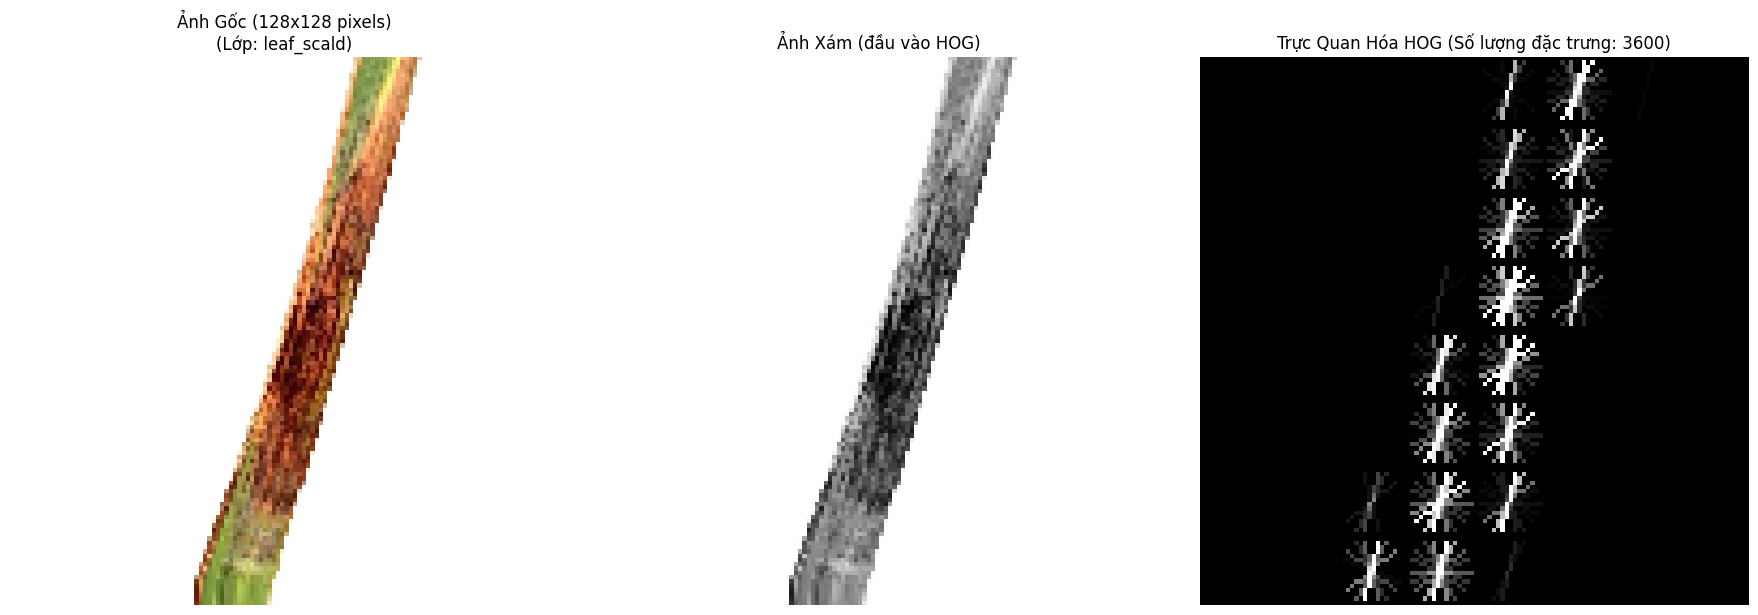

In [ ]:
#in ảnh

DATA_DIR = "/content/drive/MyDrive/DATASET/Lua"
categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]
HOG_IMAGE_SIZE = (128, 128)
HOG_PIXELS_PER_CELL = (16, 16)
HOG_CELLS_PER_BLOCK = (4, 4)


# Chọn ngẫu nhiên một lớp và một ảnh
random_category_name = np.random.choice(categories)
random_class_path = os.path.join(DATA_DIR, random_category_name)

# Đảm bảo thư mục lớp không rỗng
if not os.listdir(random_class_path):
    print(f"Lỗi: Thư mục '{random_class_path}' trống. Không thể chọn ảnh mẫu.")
    exit()

random_image_name = np.random.choice(os.listdir(random_class_path))
random_image_path = os.path.join(random_class_path, random_image_name)

# Đọc ảnh
sample_img = cv2.imread(random_image_path)

if sample_img is None:
    print(f"Lỗi: Không thể đọc ảnh từ đường dẫn: {random_image_path}")
else:
    # Chuyển đổi ảnh sang không gian màu RGB để hiển thị đúng
    sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

    # Resize ảnh về kích thước chuẩn
    sample_img_resized = cv2.resize(sample_img_rgb, HOG_IMAGE_SIZE)

    # Chuyển đổi ảnh sang ảnh xám để tính HOG
    sample_img_gray = cv2.cvtColor(sample_img_resized, cv2.COLOR_RGB2GRAY)

    # Tính toán đặc trưng HOG và ảnh HOG
    # visualize=True để lấy ảnh HOG
    hog_features, hog_image = hog(
        sample_img_gray,
        pixels_per_cell=HOG_PIXELS_PER_CELL,
        cells_per_block=HOG_CELLS_PER_BLOCK,
        feature_vector=True,
        visualize=True
    )

    # Tăng cường độ tương phản cho ảnh HOG để dễ nhìn hơn
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))


    # ====== In ra số lượng đặc trưng HOG ======
    print(f"\nSố lượng đặc trưng HOG trích xuất: {len(hog_features)}")

    # ====== Hiển thị ảnh gốc, ảnh xám (đã resize) và ảnh HOG ======
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Ảnh gốc (đã resize)
    axes[0].imshow(sample_img_resized)
    axes[0].set_title(f"Ảnh Gốc ({HOG_IMAGE_SIZE[0]}x{HOG_IMAGE_SIZE[1]} pixels)\n(Lớp: {random_category_name})")
    axes[0].axis('off')

    # Ảnh xám (đầu vào cho HOG)
    axes[1].imshow(sample_img_gray, cmap='gray')
    axes[1].set_title("Ảnh Xám (đầu vào HOG)")
    axes[1].axis('off')

    # Ảnh HOG (trực quan hóa các gradient)
    axes[2].imshow(hog_image_rescaled, cmap='gray') # Sử dụng ảnh HOG đã tăng cường tương phản
    axes[2].set_title(f"Trực Quan Hóa HOG (Số lượng đặc trưng: {len(hog_features)})")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


Số lượng mẫu:
- Train: 34940 mẫu
- Validation: 874 mẫu
- Test: 874 mẫu

Số lượng mẫu theo từng lớp trong tập Train:
  leaf_scald (1): 6915 mẫu
  rice_hispa (2): 6915 mẫu
  healthy (3): 7125 mẫu
  sheath_blight (4): 7055 mẫu
  bacterial_leaf_blight (0): 6930 mẫu

Số lượng mẫu theo từng lớp trong tập Validation:
  bacterial_leaf_blight (0): 174 mẫu
  healthy (3): 178 mẫu
  rice_hispa (2): 173 mẫu
  leaf_scald (1): 173 mẫu
  sheath_blight (4): 176 mẫu

Số lượng mẫu theo từng lớp trong tập Test:
  bacterial_leaf_blight (0): 173 mẫu
  leaf_scald (1): 173 mẫu
  rice_hispa (2): 173 mẫu
  sheath_blight (4): 177 mẫu
  healthy (3): 178 mẫu

Đang huấn luyện mô hình SVM...

[SVM] Accuracy (val): 93.25%
[SVM] F1-score (val): 0.9327

[SVM] Accuracy (test): 94.97%
[SVM] F1-score (test): 0.9497

[SVM] Báo cáo phân loại:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.98      0.96      0.97       173
           leaf_scald       0.95      0.96      0.95    

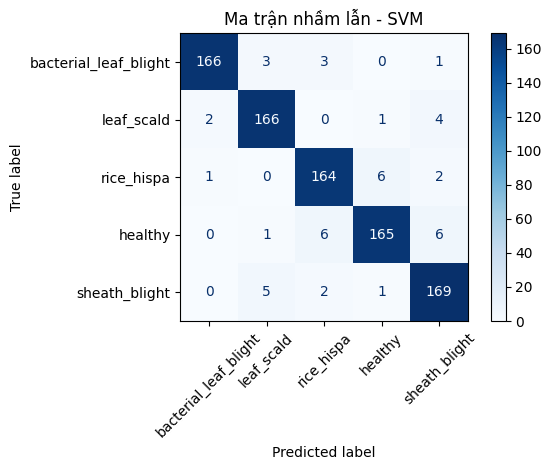

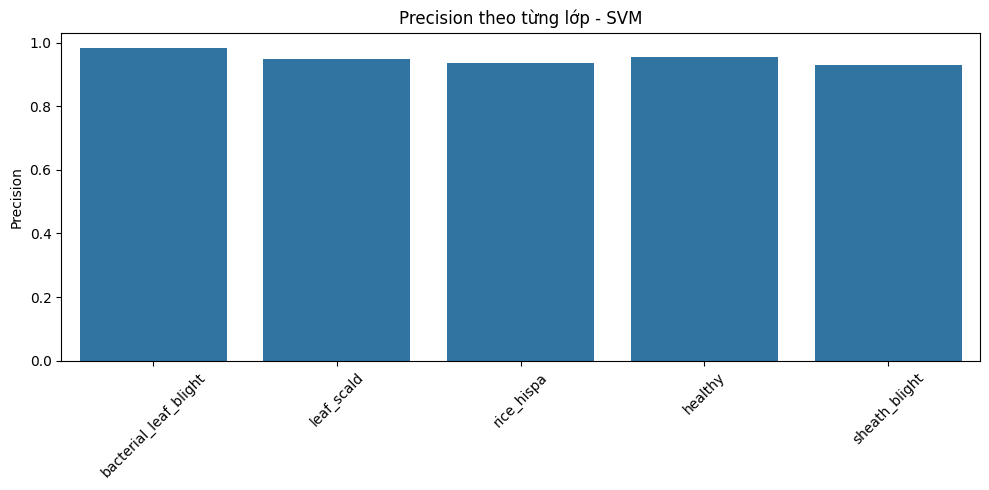

In [ ]:

# HOG +color + SVM lần 1
DATA_DIR = "/content/drive/MyDrive/Lua_16:4_HOG+Color"

X_train = np.load(os.path.join(DATA_DIR, 'X_train6.npy'))
X_val   = np.load(os.path.join(DATA_DIR, 'X_val6.npy'))
X_test  = np.load(os.path.join(DATA_DIR, 'X_test6.npy'))

y_train = np.load(os.path.join(DATA_DIR, 'y_train6.npy'))
y_val   = np.load(os.path.join(DATA_DIR, 'y_val6.npy'))
y_test  = np.load(os.path.join(DATA_DIR, 'y_test6.npy'))

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

# ====== Tổng số lượng mẫu ======
print(f"\nSố lượng mẫu:")
print(f"- Train: {len(X_train)} mẫu")
print(f"- Validation: {len(X_val)} mẫu")
print(f"- Test: {len(X_test)} mẫu")

# ====== In ra số lượng mẫu theo từng lớp ======
def print_class_distribution(y, split_name):
    print(f"\nSố lượng mẫu theo từng lớp trong tập {split_name}:")
    counter = Counter(y)
    for label, count in counter.items():
        class_name = categories[label] if label < len(categories) else f"Lớp {label}"
        print(f"  {class_name} ({label}): {count} mẫu")

print_class_distribution(y_train, "Train")
print_class_distribution(y_val, "Validation")
print_class_distribution(y_test, "Test")

# ====== Huấn luyện SVM trên train ======
print("\nĐang huấn luyện mô hình SVM...")
svm_model = SVC(kernel='rbf', C=5.0, gamma='scale')


# Huấn luyện mô hình trên toàn bộ train
svm_model.fit(X_train, y_train)

# ====== Đánh giá trên tập validation ======
y_val_pred = svm_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
print(f"\n[SVM] Accuracy (val): {val_acc*100:.2f}%")
print(f"[SVM] F1-score (val): {val_f1:.4f}")

# ====== Đánh giá trên tập test ======
y_pred = svm_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\n[SVM] Accuracy (test): {acc*100:.2f}%")
print(f"[SVM] F1-score (test): {f1:.4f}")
print("\n[SVM] Báo cáo phân loại:")
print(classification_report(y_test, y_pred, target_names=categories))

# ====== Vẽ ma trận nhầm lẫn ======
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Ma trận nhầm lẫn - SVM")
plt.tight_layout()
plt.show()

# ====== Precision theo lớp ======
report = classification_report(y_test, y_pred, target_names=categories, output_dict=True)
precision_values = [report[cat]['precision'] for cat in categories]

plt.figure(figsize=(10, 5))
sns.barplot(x=categories, y=precision_values)
plt.ylabel("Precision")
plt.title("Precision theo từng lớp - SVM")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Số lượng mẫu:
- Train: 34940 mẫu
- Validation: 874 mẫu
- Test: 874 mẫu

Số lượng mẫu theo từng lớp trong tập Train:
  bacterial_leaf_blight (0): 6930 mẫu
  rice_hispa (2): 6915 mẫu
  leaf_scald (1): 6915 mẫu
  healthy (3): 7125 mẫu
  sheath_blight (4): 7055 mẫu

Số lượng mẫu theo từng lớp trong tập Validation:
  sheath_blight (4): 177 mẫu
  healthy (3): 178 mẫu
  leaf_scald (1): 173 mẫu
  bacterial_leaf_blight (0): 173 mẫu
  rice_hispa (2): 173 mẫu

Số lượng mẫu theo từng lớp trong tập Test:
  bacterial_leaf_blight (0): 174 mẫu
  sheath_blight (4): 176 mẫu
  rice_hispa (2): 173 mẫu
  leaf_scald (1): 173 mẫu
  healthy (3): 178 mẫu

Đang huấn luyện mô hình SVM...

[SVM] Accuracy (val): 90.73%
[SVM] F1-score (val): 0.9076

[SVM] Accuracy (test): 90.50%
[SVM] F1-score (test): 0.9056

[SVM] Báo cáo phân loại:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.97      0.87      0.92       174
           leaf_scald       0.84      0.91      0.87    

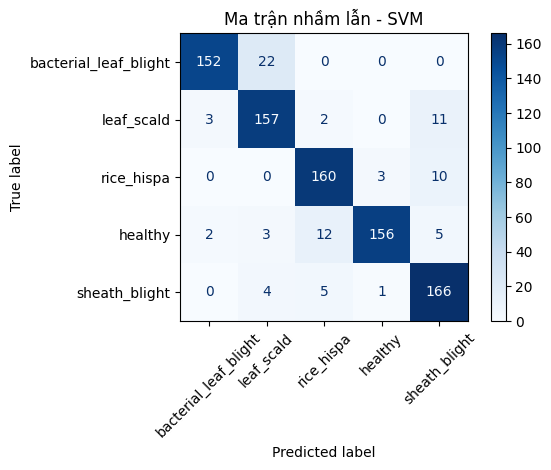

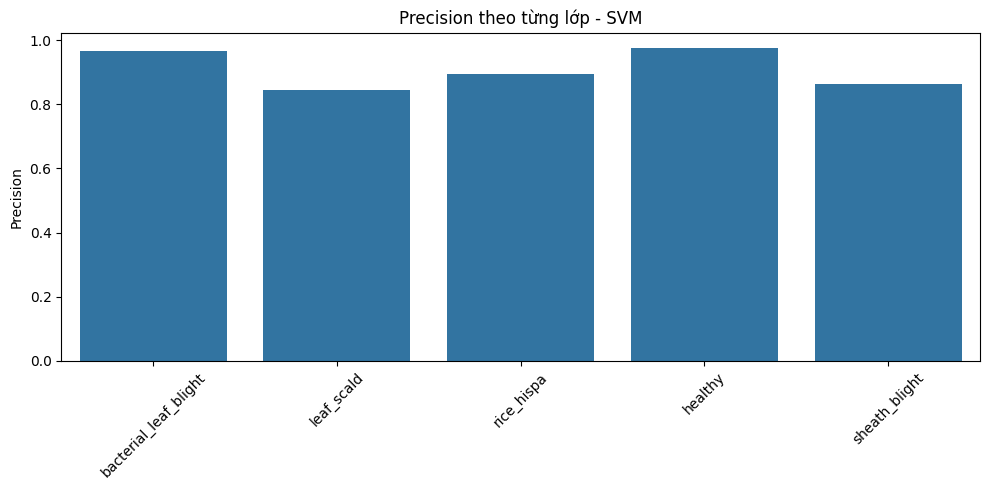

In [3]:

# color + SVM lần 1
DATA_DIR = "/content/drive/MyDrive/Lua_16:4_Color"

X_train = np.load(os.path.join(DATA_DIR, 'X_train1.npy'))
X_val   = np.load(os.path.join(DATA_DIR, 'X_val1.npy'))
X_test  = np.load(os.path.join(DATA_DIR, 'X_test1.npy'))

y_train = np.load(os.path.join(DATA_DIR, 'y_train1.npy'))
y_val   = np.load(os.path.join(DATA_DIR, 'y_val1.npy'))
y_test  = np.load(os.path.join(DATA_DIR, 'y_test1.npy'))

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

# ====== Tổng số lượng mẫu ======
print(f"\nSố lượng mẫu:")
print(f"- Train: {len(X_train)} mẫu")
print(f"- Validation: {len(X_val)} mẫu")
print(f"- Test: {len(X_test)} mẫu")

# ====== In ra số lượng mẫu theo từng lớp ======
def print_class_distribution(y, split_name):
    print(f"\nSố lượng mẫu theo từng lớp trong tập {split_name}:")
    counter = Counter(y)
    for label, count in counter.items():
        class_name = categories[label] if label < len(categories) else f"Lớp {label}"
        print(f"  {class_name} ({label}): {count} mẫu")

print_class_distribution(y_train, "Train")
print_class_distribution(y_val, "Validation")
print_class_distribution(y_test, "Test")

# ====== Huấn luyện SVM trên train ======
print("\nĐang huấn luyện mô hình SVM...")
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')


# Huấn luyện mô hình trên toàn bộ train
svm_model.fit(X_train, y_train)

# ====== Đánh giá trên tập validation ======
y_val_pred = svm_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
print(f"\n[SVM] Accuracy (val): {val_acc*100:.2f}%")
print(f"[SVM] F1-score (val): {val_f1:.4f}")

# ====== Đánh giá trên tập test ======
y_pred = svm_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\n[SVM] Accuracy (test): {acc*100:.2f}%")
print(f"[SVM] F1-score (test): {f1:.4f}")
print("\n[SVM] Báo cáo phân loại:")
print(classification_report(y_test, y_pred, target_names=categories))

model_filename = os.path.join(DATA_DIR, f'svm_model.pkl')
joblib.dump(svm_model, model_filename)
print(f"\n[SVM] Đã lưu mô hình vào: {model_filename}")

# ====== Vẽ ma trận nhầm lẫn ======
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Ma trận nhầm lẫn - SVM")
plt.tight_layout()
plt.show()

# ====== Precision theo lớp ======
report = classification_report(y_test, y_pred, target_names=categories, output_dict=True)
precision_values = [report[cat]['precision'] for cat in categories]

plt.figure(figsize=(10, 5))
sns.barplot(x=categories, y=precision_values)
plt.ylabel("Precision")
plt.title("Precision theo từng lớp - SVM")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Số lượng mẫu:
- Train: 34940 mẫu
- Validation: 874 mẫu
- Test: 874 mẫu

Số lượng mẫu theo từng lớp trong tập Train:
  healthy (3): 7125 mẫu
  leaf_scald (1): 6915 mẫu
  bacterial_leaf_blight (0): 6930 mẫu
  rice_hispa (2): 6915 mẫu
  sheath_blight (4): 7055 mẫu

Số lượng mẫu theo từng lớp trong tập Validation:
  leaf_scald (1): 173 mẫu
  rice_hispa (2): 173 mẫu
  bacterial_leaf_blight (0): 173 mẫu
  healthy (3): 178 mẫu
  sheath_blight (4): 177 mẫu

Số lượng mẫu theo từng lớp trong tập Test:
  rice_hispa (2): 173 mẫu
  leaf_scald (1): 173 mẫu
  sheath_blight (4): 176 mẫu
  healthy (3): 178 mẫu
  bacterial_leaf_blight (0): 174 mẫu

Đang huấn luyện mô hình SVM...

[SVM] Accuracy (val): 90.96%
[SVM] F1-score (val): 0.9099

[SVM] Accuracy (test): 90.39%
[SVM] F1-score (test): 0.9042

[SVM] Báo cáo phân loại:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.98      0.95      0.96       174
           leaf_scald       0.96      0.90      0.93    

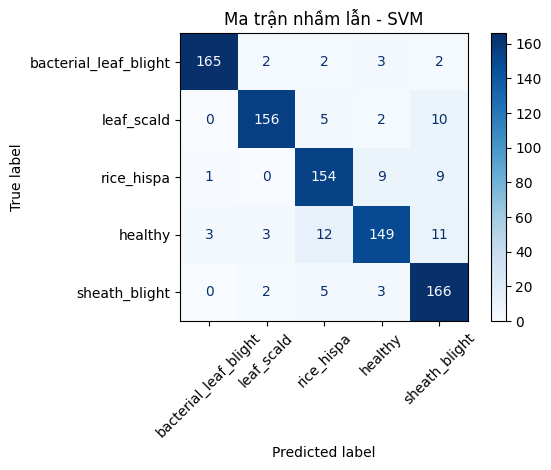

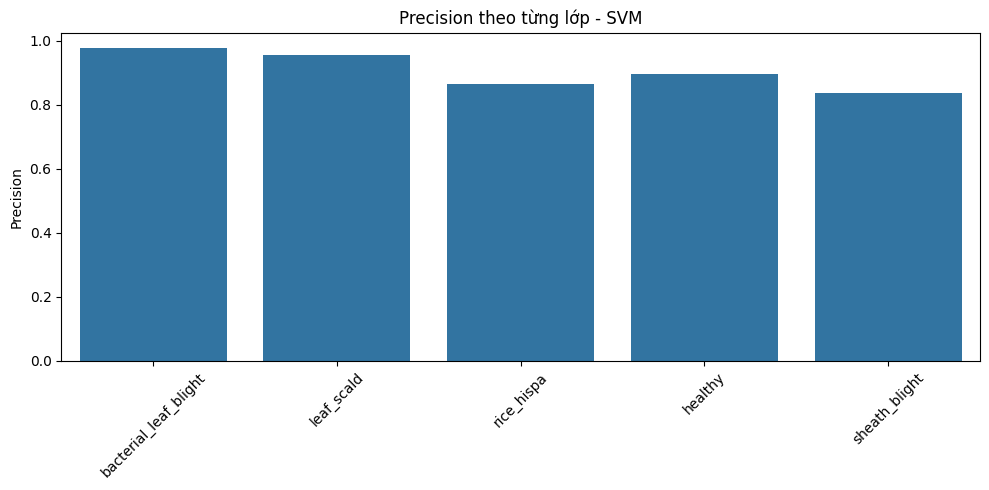

In [ ]:

# HOG + SVM lần 1 minmax
DATA_DIR = "/content/drive/MyDrive/Lua_16:4_HOG+Color_8AU"

X_train = np.load(os.path.join(DATA_DIR, 'X_train1.npy'))
X_val   = np.load(os.path.join(DATA_DIR, 'X_val1.npy'))
X_test  = np.load(os.path.join(DATA_DIR, 'X_test1.npy'))

y_train = np.load(os.path.join(DATA_DIR, 'y_train1.npy'))
y_val   = np.load(os.path.join(DATA_DIR, 'y_val1.npy'))
y_test  = np.load(os.path.join(DATA_DIR, 'y_test1.npy'))

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

# ====== Tổng số lượng mẫu ======
print(f"\nSố lượng mẫu:")
print(f"- Train: {len(X_train)} mẫu")
print(f"- Validation: {len(X_val)} mẫu")
print(f"- Test: {len(X_test)} mẫu")

# ====== In ra số lượng mẫu theo từng lớp ======
def print_class_distribution(y, split_name):
    print(f"\nSố lượng mẫu theo từng lớp trong tập {split_name}:")
    counter = Counter(y)
    for label, count in counter.items():
        class_name = categories[label] if label < len(categories) else f"Lớp {label}"
        print(f"  {class_name} ({label}): {count} mẫu")

print_class_distribution(y_train, "Train")
print_class_distribution(y_val, "Validation")
print_class_distribution(y_test, "Test")

# ====== Huấn luyện SVM trên train ======
print("\nĐang huấn luyện mô hình SVM...")
svm_model = SVC(kernel='rbf', C=20.0, gamma='scale')


# Huấn luyện mô hình trên toàn bộ train
svm_model.fit(X_train, y_train)

# ====== Đánh giá trên tập validation ======
y_val_pred = svm_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
print(f"\n[SVM] Accuracy (val): {val_acc*100:.2f}%")
print(f"[SVM] F1-score (val): {val_f1:.4f}")

# ====== Đánh giá trên tập test ======
y_pred = svm_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\n[SVM] Accuracy (test): {acc*100:.2f}%")
print(f"[SVM] F1-score (test): {f1:.4f}")
print("\n[SVM] Báo cáo phân loại:")
print(classification_report(y_test, y_pred, target_names=categories))

# ====== Vẽ ma trận nhầm lẫn ======
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Ma trận nhầm lẫn - SVM")
plt.tight_layout()
plt.show()

# ====== Precision theo lớp ======
report = classification_report(y_test, y_pred, target_names=categories, output_dict=True)
precision_values = [report[cat]['precision'] for cat in categories]

plt.figure(figsize=(10, 5))
sns.barplot(x=categories, y=precision_values)
plt.ylabel("Precision")
plt.title("Precision theo từng lớp - SVM")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Số lượng mẫu:
- Train: 27952 mẫu
- Validation: 874 mẫu
- Test: 874 mẫu

Số lượng mẫu theo từng lớp trong tập Train:
  sheath_blight (4): 5644 mẫu
  bacterial_leaf_blight (0): 5544 mẫu
  rice_hispa (2): 5532 mẫu
  leaf_scald (1): 5532 mẫu
  healthy (3): 5700 mẫu

Số lượng mẫu theo từng lớp trong tập Validation:
  sheath_blight (4): 177 mẫu
  bacterial_leaf_blight (0): 173 mẫu
  healthy (3): 178 mẫu
  rice_hispa (2): 173 mẫu
  leaf_scald (1): 173 mẫu

Số lượng mẫu theo từng lớp trong tập Test:
  leaf_scald (1): 173 mẫu
  bacterial_leaf_blight (0): 174 mẫu
  rice_hispa (2): 173 mẫu
  sheath_blight (4): 176 mẫu
  healthy (3): 178 mẫu

Đang huấn luyện mô hình SVM...

[SVM] Accuracy (val): 84.10%
[SVM] F1-score (val): 0.8431

[SVM] Accuracy (test): 84.55%
[SVM] F1-score (test): 0.8474

[SVM] Báo cáo phân loại:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.95      0.95      0.95       174
           leaf_scald       0.93      0.86      0.89    

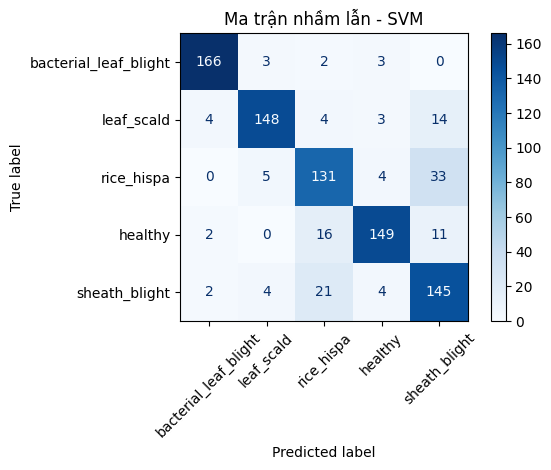

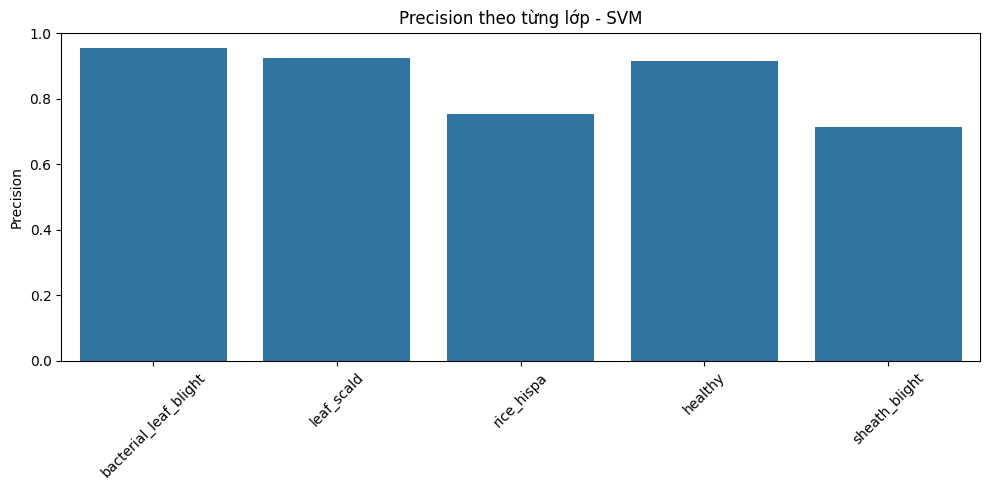

In [ ]:

# HOG + SVM lần 1 minmax = 8.2_HOG
DATA_DIR = "/content/drive/MyDrive/Lua_8.2_HOG"

X_train = np.load(os.path.join(DATA_DIR, 'X_train1.npy'))
X_val   = np.load(os.path.join(DATA_DIR, 'X_val1.npy'))
X_test  = np.load(os.path.join(DATA_DIR, 'X_test1.npy'))

y_train = np.load(os.path.join(DATA_DIR, 'y_train1.npy'))
y_val   = np.load(os.path.join(DATA_DIR, 'y_val1.npy'))
y_test  = np.load(os.path.join(DATA_DIR, 'y_test1.npy'))

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

# ====== Tổng số lượng mẫu ======
print(f"\nSố lượng mẫu:")
print(f"- Train: {len(X_train)} mẫu")
print(f"- Validation: {len(X_val)} mẫu")
print(f"- Test: {len(X_test)} mẫu")

# ====== In ra số lượng mẫu theo từng lớp ======
def print_class_distribution(y, split_name):
    print(f"\nSố lượng mẫu theo từng lớp trong tập {split_name}:")
    counter = Counter(y)
    for label, count in counter.items():
        class_name = categories[label] if label < len(categories) else f"Lớp {label}"
        print(f"  {class_name} ({label}): {count} mẫu")

print_class_distribution(y_train, "Train")
print_class_distribution(y_val, "Validation")
print_class_distribution(y_test, "Test")

# ====== Huấn luyện SVM trên train ======
print("\nĐang huấn luyện mô hình SVM...")
svm_model = SVC(kernel='rbf', C=20.0, gamma='scale')


# Huấn luyện mô hình trên toàn bộ train
svm_model.fit(X_train, y_train)

# ====== Đánh giá trên tập validation ======
y_val_pred = svm_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
print(f"\n[SVM] Accuracy (val): {val_acc*100:.2f}%")
print(f"[SVM] F1-score (val): {val_f1:.4f}")

# ====== Đánh giá trên tập test ======
y_pred = svm_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\n[SVM] Accuracy (test): {acc*100:.2f}%")
print(f"[SVM] F1-score (test): {f1:.4f}")
print("\n[SVM] Báo cáo phân loại:")
print(classification_report(y_test, y_pred, target_names=categories))

# ====== Vẽ ma trận nhầm lẫn ======
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Ma trận nhầm lẫn - SVM")
plt.tight_layout()
plt.show()

# ====== Precision theo lớp ======
report = classification_report(y_test, y_pred, target_names=categories, output_dict=True)
precision_values = [report[cat]['precision'] for cat in categories]

plt.figure(figsize=(10, 5))
sns.barplot(x=categories, y=precision_values)
plt.ylabel("Precision")
plt.title("Precision theo từng lớp - SVM")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Số lượng mẫu:
- Train: 27952 mẫu
- Validation: 874 mẫu
- Test: 874 mẫu

Số lượng mẫu theo từng lớp trong tập Train:
  bacterial_leaf_blight (0): 5544 mẫu
  sheath_blight (4): 5644 mẫu
  leaf_scald (1): 5532 mẫu
  healthy (3): 5700 mẫu
  rice_hispa (2): 5532 mẫu

Số lượng mẫu theo từng lớp trong tập Validation:
  bacterial_leaf_blight (0): 173 mẫu
  sheath_blight (4): 177 mẫu
  healthy (3): 178 mẫu
  rice_hispa (2): 173 mẫu
  leaf_scald (1): 173 mẫu

Số lượng mẫu theo từng lớp trong tập Test:
  leaf_scald (1): 173 mẫu
  sheath_blight (4): 176 mẫu
  healthy (3): 178 mẫu
  bacterial_leaf_blight (0): 174 mẫu
  rice_hispa (2): 173 mẫu

Đang huấn luyện mô hình SVM...

[SVM] Accuracy (val): 87.30%
[SVM] F1-score (val): 0.8749

[SVM] Accuracy (test): 90.62%
[SVM] F1-score (test): 0.9069

[SVM] Báo cáo phân loại:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.98      0.97      0.97       174
           leaf_scald       0.97      0.90      0.93    

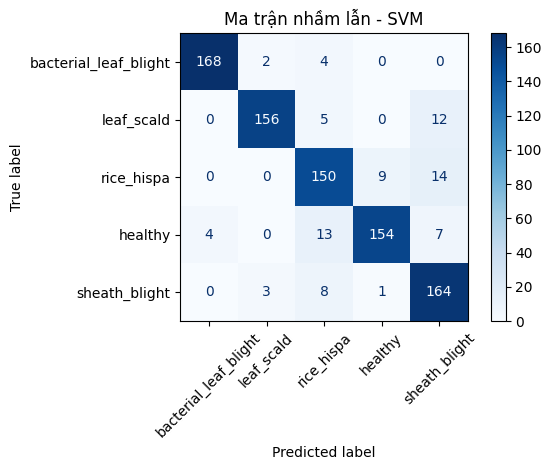

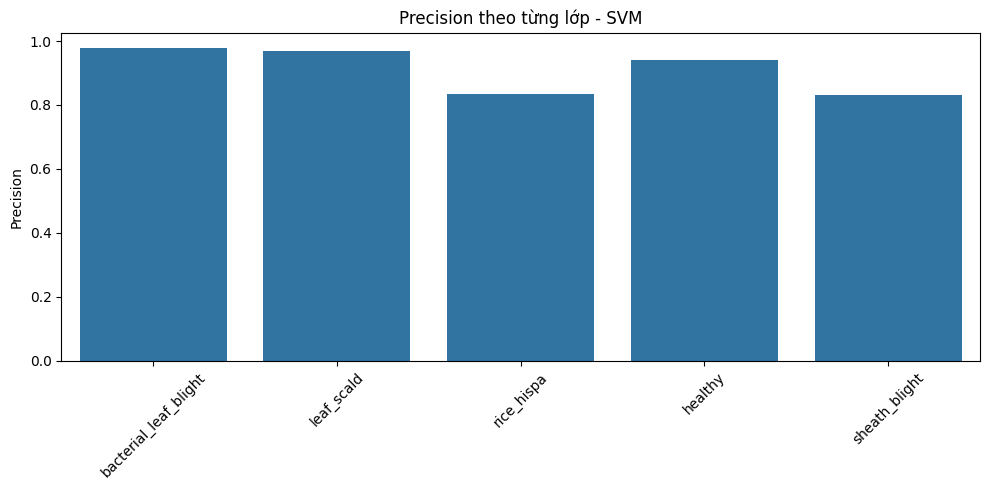

In [ ]:

#  Lua_8:2_HOG+Color 8au
DATA_DIR = "/content/drive/MyDrive/Lua_8:2_HOG+Color"

X_train = np.load(os.path.join(DATA_DIR, 'X_train1.npy'))
X_val   = np.load(os.path.join(DATA_DIR, 'X_val1.npy'))
X_test  = np.load(os.path.join(DATA_DIR, 'X_test1.npy'))

y_train = np.load(os.path.join(DATA_DIR, 'y_train1.npy'))
y_val   = np.load(os.path.join(DATA_DIR, 'y_val1.npy'))
y_test  = np.load(os.path.join(DATA_DIR, 'y_test1.npy'))

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

# ====== Tổng số lượng mẫu ======
print(f"\nSố lượng mẫu:")
print(f"- Train: {len(X_train)} mẫu")
print(f"- Validation: {len(X_val)} mẫu")
print(f"- Test: {len(X_test)} mẫu")

# ====== In ra số lượng mẫu theo từng lớp ======
def print_class_distribution(y, split_name):
    print(f"\nSố lượng mẫu theo từng lớp trong tập {split_name}:")
    counter = Counter(y)
    for label, count in counter.items():
        class_name = categories[label] if label < len(categories) else f"Lớp {label}"
        print(f"  {class_name} ({label}): {count} mẫu")

print_class_distribution(y_train, "Train")
print_class_distribution(y_val, "Validation")
print_class_distribution(y_test, "Test")

# ====== Huấn luyện SVM trên train ======
print("\nĐang huấn luyện mô hình SVM...")
svm_model = SVC(kernel='rbf', C=20.0, gamma='scale')


# Huấn luyện mô hình trên toàn bộ train
svm_model.fit(X_train, y_train)

# ====== Đánh giá trên tập validation ======
y_val_pred = svm_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
print(f"\n[SVM] Accuracy (val): {val_acc*100:.2f}%")
print(f"[SVM] F1-score (val): {val_f1:.4f}")

# ====== Đánh giá trên tập test ======
y_pred = svm_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"\n[SVM] Accuracy (test): {acc*100:.2f}%")
print(f"[SVM] F1-score (test): {f1:.4f}")
print("\n[SVM] Báo cáo phân loại:")
print(classification_report(y_test, y_pred, target_names=categories))

# ====== Vẽ ma trận nhầm lẫn ======
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Ma trận nhầm lẫn - SVM")
plt.tight_layout()
plt.show()

# ====== Precision theo lớp ======
report = classification_report(y_test, y_pred, target_names=categories, output_dict=True)
precision_values = [report[cat]['precision'] for cat in categories]

plt.figure(figsize=(10, 5))
sns.barplot(x=categories, y=precision_values)
plt.ylabel("Precision")
plt.title("Precision theo từng lớp - SVM")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Số lượng mẫu:
- Train: 34940 mẫu
- Validation: 874 mẫu
- Test: 874 mẫu

Số lượng mẫu theo từng lớp trong tập Train:
  bacterial_leaf_blight (0): 6930 mẫu
  leaf_scald (1): 6915 mẫu
  rice_hispa (2): 6915 mẫu
  healthy (3): 7125 mẫu
  sheath_blight (4): 7055 mẫu

Số lượng mẫu theo từng lớp trong tập Validation:
  bacterial_leaf_blight (0): 174 mẫu
  leaf_scald (1): 173 mẫu
  rice_hispa (2): 173 mẫu
  healthy (3): 178 mẫu
  sheath_blight (4): 176 mẫu

Số lượng mẫu theo từng lớp trong tập Test:
  bacterial_leaf_blight (0): 173 mẫu
  leaf_scald (1): 173 mẫu
  rice_hispa (2): 173 mẫu
  healthy (3): 178 mẫu
  sheath_blight (4): 177 mẫu

 Mô hình vòng 1 đã tồn tại. Tải và đánh giá lại.
   Đã tải | Test - Accuracy: 95.31% | F1-score: 0.9532
          | Val  - Accuracy: 93.14% | F1-score: 0.9313

 Mô hình vòng 2 đã tồn tại. Tải và đánh giá lại.
   Đã tải | Test - Accuracy: 94.51% | F1-score: 0.9452
          | Val  - Accuracy: 93.71% | F1-score: 0.9372

 Mô hình vòng 3 đã tồn tại. Tải và đánh 

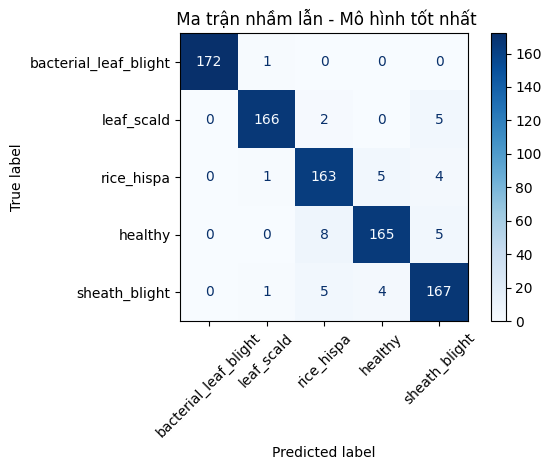

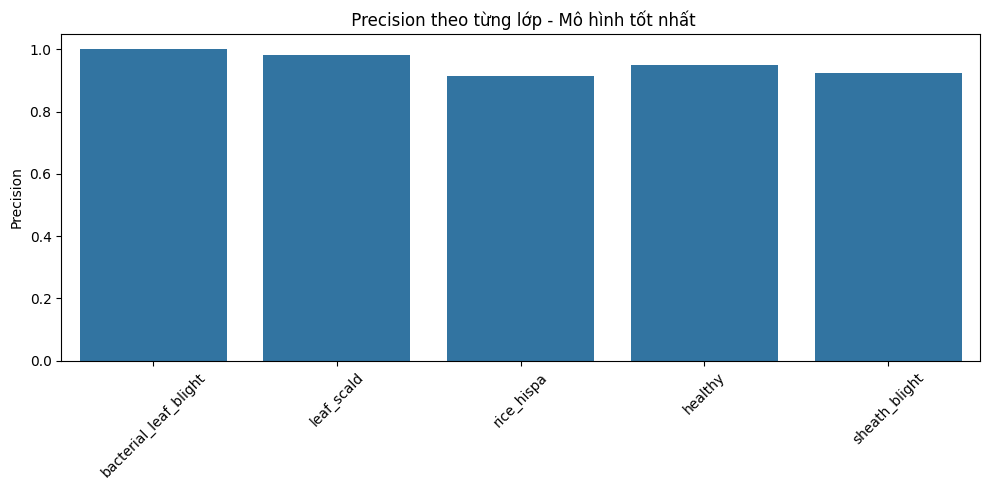


 Đã lưu mô hình SVM tốt nhất với F1-score: 0.9532 vào: /content/drive/MyDrive/Lua_16:4_HOG+Color/svm_model_best.pkl


In [ ]:
# Train 6 lần HOG + Color + SVM
DATA_DIR = "/content/drive/MyDrive/Lua_16:4_HOG+Color"
MODEL_SAVE_DIR = os.path.join(DATA_DIR, 'saved_svm_rounds') # Thư mục để lưu các mô hình của từng vòng
os.makedirs(MODEL_SAVE_DIR, exist_ok=True) # Tạo thư mục nếu chưa tồn tại

X_train_initial = np.load(os.path.join(DATA_DIR, 'X_train1.npy'))
X_val_initial   = np.load(os.path.join(DATA_DIR, 'X_val1.npy'))
X_test_initial  = np.load(os.path.join(DATA_DIR, 'X_test1.npy'))

y_train_initial = np.load(os.path.join(DATA_DIR, 'y_train1.npy'))
y_val_initial   = np.load(os.path.join(DATA_DIR, 'y_val1.npy'))
y_test_initial  = np.load(os.path.join(DATA_DIR, 'y_test1.npy'))

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

print(f"\nSố lượng mẫu:")
print(f"- Train: {len(X_train_initial)} mẫu")
print(f"- Validation: {len(X_val_initial)} mẫu")
print(f"- Test: {len(X_test_initial)} mẫu")

# ====== In ra số lượng mẫu theo từng lớp ======
def print_class_distribution(y, split_name):
    print(f"\nSố lượng mẫu theo từng lớp trong tập {split_name}:")
    counter = Counter(y)
    # Sắp xếp các lớp theo nhãn để đảm bảo thứ tự nhất quán
    sorted_labels = sorted(counter.keys())
    for label in sorted_labels:
        count = counter[label]
        class_name = categories[label] if label < len(categories) else f"Lớp {label}"
        print(f"  {class_name} ({label}): {count} mẫu")

print_class_distribution(y_train_initial, "Train")
print_class_distribution(y_val_initial, "Validation")
print_class_distribution(y_test_initial, "Test")

accuracy_list = []
f1_list = []
best_f1 = -1
best_model = None
best_preds = None
best_y_test = None

num_rounds = 6

# Xác định vòng huấn luyện bắt đầu
start_round = 1
# Kiểm tra các mô hình đã lưu để tìm vòng chưa hoàn thành
for i in range(1, num_rounds + 1):
    model_path_round = os.path.join(MODEL_SAVE_DIR, f'svm_model_round_{i}.pkl')
    if not os.path.exists(model_path_round):
        start_round = i
        print(f"\n Vòng huấn luyện chưa hoàn thành. Bắt đầu từ vòng {start_round}.")
        break
    else:
        print(f"\n Mô hình vòng {i} đã tồn tại. Tải và đánh giá lại.")

        # Tải dữ liệu test
        X_test_round = np.load(os.path.join(DATA_DIR, f'X_test{i}.npy'))
        y_test_round = np.load(os.path.join(DATA_DIR, f'y_test{i}.npy'))

        # Tải dữ liệu validation
        X_val_round = np.load(os.path.join(DATA_DIR, f'X_val{i}.npy'))
        y_val_round = np.load(os.path.join(DATA_DIR, f'y_val{i}.npy'))

        # Tải mô hình
        loaded_model = joblib.load(model_path_round)

        # Dự đoán và đánh giá trên test
        y_pred_test_loaded = loaded_model.predict(X_test_round)
        acc_test_loaded = accuracy_score(y_test_round, y_pred_test_loaded)
        f1_test_loaded = f1_score(y_test_round, y_pred_test_loaded, average='weighted')

        # Dự đoán và đánh giá trên validation
        y_pred_val_loaded = loaded_model.predict(X_val_round)
        acc_val_loaded = accuracy_score(y_val_round, y_pred_val_loaded)
        f1_val_loaded = f1_score(y_val_round, y_pred_val_loaded, average='weighted')

        # Ghi lại kết quả
        accuracy_list.append(acc_test_loaded)
        f1_list.append(f1_test_loaded)

        print(f"   Đã tải | Test - Accuracy: {acc_test_loaded*100:.2f}% | F1-score: {f1_test_loaded:.4f}")
        print(f"          | Val  - Accuracy: {acc_val_loaded*100:.2f}% | F1-score: {f1_val_loaded:.4f}")

        # Cập nhật mô hình tốt nhất theo F1-score test
        if f1_test_loaded > best_f1:
            best_f1 = f1_test_loaded
            best_model = loaded_model
            best_preds = y_pred_test_loaded
            best_y_test = y_test_round



# Bắt đầu vòng lặp huấn luyện từ vòng đã xác định
for i in range(start_round, num_rounds + 1):
    model_path_round = os.path.join(MODEL_SAVE_DIR, f'svm_model_round_{i}.pkl')

    # Nếu mô hình cho vòng này đã tồn tại, bỏ qua huấn luyện
    if os.path.exists(model_path_round):
        print(f"\n Vòng huấn luyện SVM thứ {i} đã hoàn thành trước đó. Bỏ qua huấn luyện lại.")
        # Dữ liệu và kết quả đã được xử lý ở bước kiểm tra trước vòng lặp
        continue

    print(f"\n Bắt đầu huấn luyện SVM vòng thứ {i}:")

    # Tải dữ liệu cho vòng hiện tại
    X_train = np.load(os.path.join(DATA_DIR, f'X_train{i}.npy'))
    X_val   = np.load(os.path.join(DATA_DIR, f'X_val{i}.npy'))
    X_test  = np.load(os.path.join(DATA_DIR, f'X_test{i}.npy'))

    y_train = np.load(os.path.join(DATA_DIR, f'y_train{i}.npy'))
    y_val   = np.load(os.path.join(DATA_DIR, f'y_val{i}.npy'))
    y_test  = np.load(os.path.join(DATA_DIR, f'y_test{i}.npy'))

    # Khởi tạo và huấn luyện mô hình
    model = SVC(kernel='rbf', C=20.0, gamma='scale')
    model.fit(X_train, y_train)

    # Dự đoán trên test set
    y_pred_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test, average='weighted')

    # Dự đoán trên validation set
    y_pred_val = model.predict(X_val)
    acc_val = accuracy_score(y_val, y_pred_val)
    f1_val = f1_score(y_val, y_pred_val, average='weighted')

    accuracy_list.append(acc_test)
    f1_list.append(f1_test)

    print(f" Test  | Accuracy: {acc_test*100:.2f}% | F1-score: {f1_test:.4f}")
    print(f" Val   | Accuracy: {acc_val*100:.2f}% | F1-score: {f1_val:.4f}")

    # Cập nhật mô hình tốt nhất
    if f1_test > best_f1:
        best_f1 = f1_test
        best_model = model
        best_preds = y_pred_test
        best_y_test = y_test

    # Lưu mô hình của vòng hiện tại
    joblib.dump(model, model_path_round)
    print(f" Đã lưu mô hình vòng {i} vào: {model_path_round}")


# ==== Tổng kết ====
print("\n Kết quả tổng hợp:")
if accuracy_list: # Đảm bảo danh sách không rỗng trước khi tính toán
    print(f"- Accuracy trung bình: {mean(accuracy_list)*100:.2f}%")
    print(f"- Accuracy std       : {stdev(accuracy_list)*100:.2f}")
    print(f"- F1-score trung bình: {mean(f1_list):.4f}")
    print(f"- F1-score std       : {stdev(f1_list):.4f}")
else:
    print("- Không có kết quả nào được ghi nhận.")

# ==== In kết quả mô hình tốt nhất ====
if best_model:
    print("\n Mô hình có F1-score cao nhất:")
    print(f"- F1-score: {best_f1:.4f}")
    print(classification_report(best_y_test, best_preds, target_names=categories))

    # ==== Vẽ ma trận nhầm lẫn ====
    cm = confusion_matrix(best_y_test, best_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(" Ma trận nhầm lẫn - Mô hình tốt nhất")
    plt.tight_layout()
    plt.show()

    # ==== Vẽ biểu đồ precision theo từng lớp ====
    report = classification_report(best_y_test, best_preds, target_names=categories, output_dict=True)
    precision_values = [report[cat]['precision'] for cat in categories]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=categories, y=precision_values)
    plt.ylabel("Precision")
    plt.title(" Precision theo từng lớp - Mô hình tốt nhất")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ==== Lưu mô hình tốt nhất (nếu chưa được lưu) ====
    # Mô hình tốt nhất có thể là một trong các mô hình đã được lưu ở trên
    # Nếu bạn muốn lưu một bản sao riêng biệt của mô hình tốt nhất, hãy làm như sau:
    model_best_path = os.path.join(DATA_DIR, 'svm_model_best.pkl')
    joblib.dump(best_model, model_best_path)
    print(f"\n Đã lưu mô hình SVM tốt nhất với F1-score: {best_f1:.4f} vào: {model_best_path}")
else:
    print("\n Không tìm thấy mô hình tốt nhất (có thể do không có vòng huấn luyện nào hoàn thành).")




Số lượng mẫu:
- Train: 34940 mẫu
- Validation: 874 mẫu
- Test: 874 mẫu

Số lượng mẫu theo từng lớp trong tập Train:
  bacterial_leaf_blight (0): 6930 mẫu
  leaf_scald (1): 6915 mẫu
  rice_hispa (2): 6915 mẫu
  healthy (3): 7125 mẫu
  sheath_blight (4): 7055 mẫu

Số lượng mẫu theo từng lớp trong tập Validation:
  bacterial_leaf_blight (0): 174 mẫu
  leaf_scald (1): 173 mẫu
  rice_hispa (2): 173 mẫu
  healthy (3): 178 mẫu
  sheath_blight (4): 176 mẫu

Số lượng mẫu theo từng lớp trong tập Test:
  bacterial_leaf_blight (0): 173 mẫu
  leaf_scald (1): 173 mẫu
  rice_hispa (2): 173 mẫu
  healthy (3): 178 mẫu
  sheath_blight (4): 177 mẫu

 Mô hình vòng 1 đã tồn tại. Tải và đánh giá lại.
   Đã tải | Test - Accuracy: 95.54% | F1-score: 0.9555
          | Val  - Accuracy: 93.14% | F1-score: 0.9314

 Phát hiện vòng huấn luyện chưa hoàn thành. Bắt đầu từ vòng 2.

 Bắt đầu huấn luyện SVM vòng thứ 2:
 Test  | Accuracy: 94.51% | F1-score: 0.9451
 Val   | Accuracy: 93.25% | F1-score: 0.9327
 Đã lưu mô

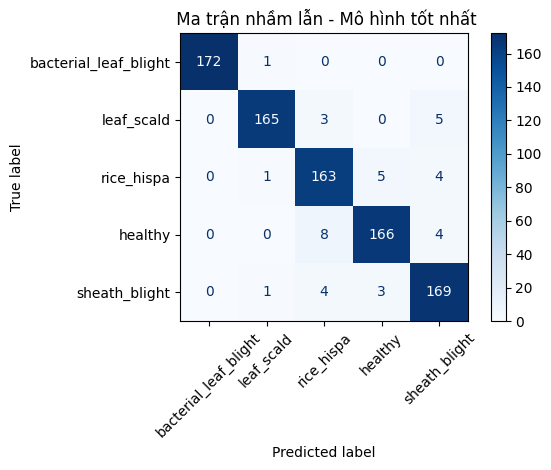

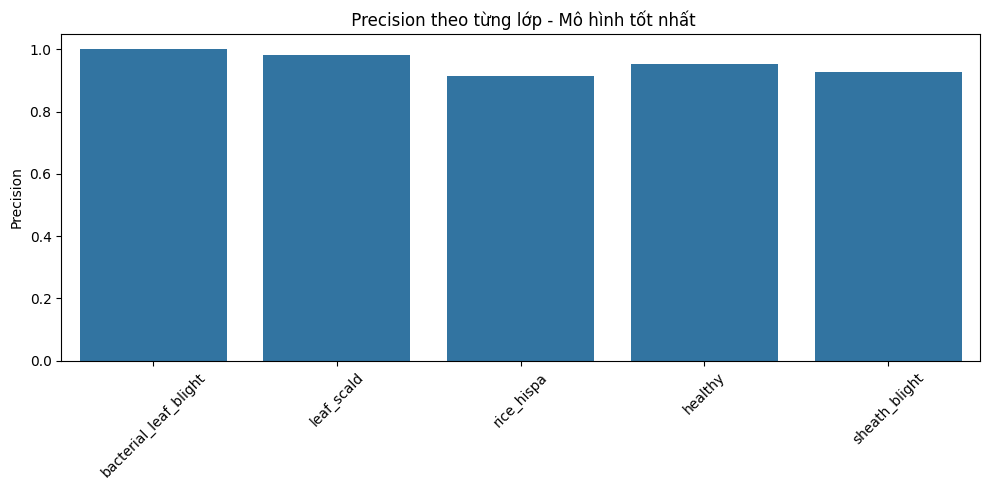


 Đã lưu mô hình SVM tốt nhất với F1-score: 0.9555 vào: /content/drive/MyDrive/Lua_16:4_HOG+Color/svm_model_bestC10.pkl


In [ ]:
# Train 6 lần HOG + Color + SVM c=10
DATA_DIR = "/content/drive/MyDrive/Lua_16:4_HOG+Color"
MODEL_SAVE_DIR = os.path.join(DATA_DIR, 'saved_svm_rounds_C10') # Thư mục để lưu các mô hình của từng vòng
os.makedirs(MODEL_SAVE_DIR, exist_ok=True) # Tạo thư mục nếu chưa tồn tại

X_train_initial = np.load(os.path.join(DATA_DIR, 'X_train1.npy'))
X_val_initial   = np.load(os.path.join(DATA_DIR, 'X_val1.npy'))
X_test_initial  = np.load(os.path.join(DATA_DIR, 'X_test1.npy'))

y_train_initial = np.load(os.path.join(DATA_DIR, 'y_train1.npy'))
y_val_initial   = np.load(os.path.join(DATA_DIR, 'y_val1.npy'))
y_test_initial  = np.load(os.path.join(DATA_DIR, 'y_test1.npy'))

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

print(f"\nSố lượng mẫu:")
print(f"- Train: {len(X_train_initial)} mẫu")
print(f"- Validation: {len(X_val_initial)} mẫu")
print(f"- Test: {len(X_test_initial)} mẫu")

# ====== In ra số lượng mẫu theo từng lớp ======
def print_class_distribution(y, split_name):
    print(f"\nSố lượng mẫu theo từng lớp trong tập {split_name}:")
    counter = Counter(y)
    # Sắp xếp các lớp theo nhãn để đảm bảo thứ tự nhất quán
    sorted_labels = sorted(counter.keys())
    for label in sorted_labels:
        count = counter[label]
        class_name = categories[label] if label < len(categories) else f"Lớp {label}"
        print(f"  {class_name} ({label}): {count} mẫu")

print_class_distribution(y_train_initial, "Train")
print_class_distribution(y_val_initial, "Validation")
print_class_distribution(y_test_initial, "Test")

accuracy_list = []
f1_list = []
best_f1 = -1
best_model = None
best_preds = None
best_y_test = None

num_rounds = 6

# Xác định vòng huấn luyện bắt đầu
start_round = 1
# Kiểm tra các mô hình đã lưu để tìm vòng chưa hoàn thành
for i in range(1, num_rounds + 1):
    model_path_round = os.path.join(MODEL_SAVE_DIR, f'svm_model_round_{i}.pkl')
    if not os.path.exists(model_path_round):
        start_round = i
        print(f"\n Phát hiện vòng huấn luyện chưa hoàn thành. Bắt đầu từ vòng {start_round}.")
        break
    else:
        print(f"\n Mô hình vòng {i} đã tồn tại. Tải và đánh giá lại.")

        # Tải dữ liệu test
        X_test_round = np.load(os.path.join(DATA_DIR, f'X_test{i}.npy'))
        y_test_round = np.load(os.path.join(DATA_DIR, f'y_test{i}.npy'))

        # Tải dữ liệu validation
        X_val_round = np.load(os.path.join(DATA_DIR, f'X_val{i}.npy'))
        y_val_round = np.load(os.path.join(DATA_DIR, f'y_val{i}.npy'))

        # Tải mô hình
        loaded_model = joblib.load(model_path_round)

        # Dự đoán và đánh giá trên test
        y_pred_test_loaded = loaded_model.predict(X_test_round)
        acc_test_loaded = accuracy_score(y_test_round, y_pred_test_loaded)
        f1_test_loaded = f1_score(y_test_round, y_pred_test_loaded, average='weighted')

        # Dự đoán và đánh giá trên validation
        y_pred_val_loaded = loaded_model.predict(X_val_round)
        acc_val_loaded = accuracy_score(y_val_round, y_pred_val_loaded)
        f1_val_loaded = f1_score(y_val_round, y_pred_val_loaded, average='weighted')

        # Ghi lại kết quả
        accuracy_list.append(acc_test_loaded)
        f1_list.append(f1_test_loaded)

        print(f"   Đã tải | Test - Accuracy: {acc_test_loaded*100:.2f}% | F1-score: {f1_test_loaded:.4f}")
        print(f"          | Val  - Accuracy: {acc_val_loaded*100:.2f}% | F1-score: {f1_val_loaded:.4f}")

        # Cập nhật mô hình tốt nhất theo F1-score test
        if f1_test_loaded > best_f1:
            best_f1 = f1_test_loaded
            best_model = loaded_model
            best_preds = y_pred_test_loaded
            best_y_test = y_test_round



# Bắt đầu vòng lặp huấn luyện từ vòng đã xác định
for i in range(start_round, num_rounds + 1):
    model_path_round = os.path.join(MODEL_SAVE_DIR, f'svm_model_round_{i}.pkl')

    # Nếu mô hình cho vòng này đã tồn tại, bỏ qua huấn luyện
    if os.path.exists(model_path_round):
        print(f"\n Vòng huấn luyện SVM thứ {i} đã hoàn thành trước đó. Bỏ qua huấn luyện lại.")
        # Dữ liệu và kết quả đã được xử lý ở bước kiểm tra trước vòng lặp
        continue

    print(f"\n Bắt đầu huấn luyện SVM vòng thứ {i}:")

    # Tải dữ liệu cho vòng hiện tại
    X_train = np.load(os.path.join(DATA_DIR, f'X_train{i}.npy'))
    X_val   = np.load(os.path.join(DATA_DIR, f'X_val{i}.npy'))
    X_test  = np.load(os.path.join(DATA_DIR, f'X_test{i}.npy'))

    y_train = np.load(os.path.join(DATA_DIR, f'y_train{i}.npy'))
    y_val   = np.load(os.path.join(DATA_DIR, f'y_val{i}.npy'))
    y_test  = np.load(os.path.join(DATA_DIR, f'y_test{i}.npy'))

    # Khởi tạo và huấn luyện mô hình
    model = SVC(kernel='rbf', C=10.0, gamma='scale')
    model.fit(X_train, y_train)

    # Dự đoán trên test set
    y_pred_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test, average='weighted')

    # Dự đoán trên validation set
    y_pred_val = model.predict(X_val)
    acc_val = accuracy_score(y_val, y_pred_val)
    f1_val = f1_score(y_val, y_pred_val, average='weighted')

    accuracy_list.append(acc_test)
    f1_list.append(f1_test)

    print(f" Test  | Accuracy: {acc_test*100:.2f}% | F1-score: {f1_test:.4f}")
    print(f" Val   | Accuracy: {acc_val*100:.2f}% | F1-score: {f1_val:.4f}")

    # Cập nhật mô hình tốt nhất
    if f1_test > best_f1:
        best_f1 = f1_test
        best_model = model
        best_preds = y_pred_test
        best_y_test = y_test

    # Lưu mô hình của vòng hiện tại
    joblib.dump(model, model_path_round)
    print(f" Đã lưu mô hình vòng {i} vào: {model_path_round}")


# ==== Tổng kết ====
print("\n Kết quả tổng hợp:")
if accuracy_list: # Đảm bảo danh sách không rỗng trước khi tính toán
    print(f"- Accuracy trung bình: {mean(accuracy_list)*100:.2f}%")
    print(f"- Accuracy std       : {stdev(accuracy_list)*100:.2f}")
    print(f"- F1-score trung bình: {mean(f1_list):.4f}")
    print(f"- F1-score std       : {stdev(f1_list):.4f}")
else:
    print("- Không có kết quả nào được ghi nhận.")

if best_model:
    print("\n Mô hình có F1-score cao nhất:")
    print(f"- F1-score: {best_f1:.4f}")
    print(classification_report(best_y_test, best_preds, target_names=categories))

    # ==== Vẽ ma trận nhầm lẫn ====
    cm = confusion_matrix(best_y_test, best_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(" Ma trận nhầm lẫn - Mô hình tốt nhất")
    plt.tight_layout()
    plt.show()

    # ==== Vẽ biểu đồ precision theo từng lớp ====
    report = classification_report(best_y_test, best_preds, target_names=categories, output_dict=True)
    precision_values = [report[cat]['precision'] for cat in categories]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=categories, y=precision_values)
    plt.ylabel("Precision")
    plt.title(" Precision theo từng lớp - Mô hình tốt nhất")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    model_best_path = os.path.join(DATA_DIR, 'svm_model_bestC10.pkl')
    joblib.dump(best_model, model_best_path)
    print(f"\n Đã lưu mô hình SVM tốt nhất với F1-score: {best_f1:.4f} vào: {model_best_path}")
else:
    print("\n Không tìm thấy mô hình tốt nhất (có thể do không có vòng huấn luyện nào hoàn thành).")




Đang huấn luyện mô hình Random Forest...

[Random Forest] Accuracy (val): 84.10%
[Random Forest] F1-score (val): 0.8431

[Random Forest] Accuracy (test): 85.35%
[Random Forest] F1-score (test): 0.8569

[Random Forest] Báo cáo phân loại:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.98      0.92      0.95       173
           leaf_scald       0.96      0.80      0.87       173
           rice_hispa       0.71      0.87      0.78       173
              healthy       0.98      0.76      0.86       178
        sheath_blight       0.75      0.91      0.82       177

             accuracy                           0.85       874
            macro avg       0.88      0.85      0.86       874
         weighted avg       0.88      0.85      0.86       874



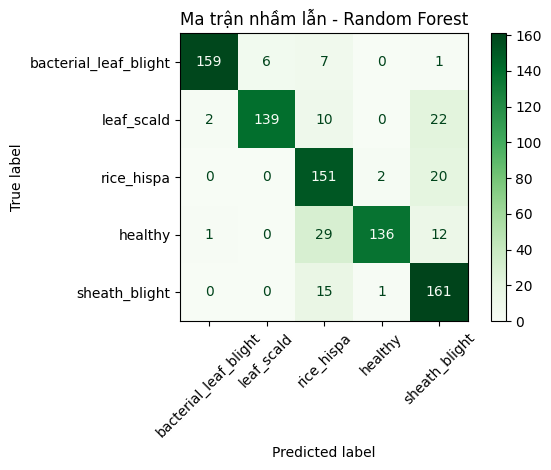

In [ ]:
#  Mô hình Random Forest

DATA_DIR = "/content/drive/MyDrive/Lua_16:4_HOG+Color"

X_train = np.load(os.path.join(DATA_DIR, 'X_train1.npy'))
X_val   = np.load(os.path.join(DATA_DIR, 'X_val1.npy'))
X_test  = np.load(os.path.join(DATA_DIR, 'X_test1.npy'))

y_train = np.load(os.path.join(DATA_DIR, 'y_train1.npy'))
y_val   = np.load(os.path.join(DATA_DIR, 'y_val1.npy'))
y_test  = np.load(os.path.join(DATA_DIR, 'y_test1.npy'))

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]
print("\nĐang huấn luyện mô hình Random Forest...")
rf_model = RandomForestClassifier(n_estimators=150, random_state=42)
rf_model.fit(X_train, y_train)

# ====== Đánh giá trên tập validation ======
y_val_pred_rf = rf_model.predict(X_val)
val_acc_rf = accuracy_score(y_val, y_val_pred_rf)
val_f1_rf = f1_score(y_val, y_val_pred_rf, average='weighted')
print(f"\n[Random Forest] Accuracy (val): {val_acc_rf*100:.2f}%")
print(f"[Random Forest] F1-score (val): {val_f1_rf:.4f}")

# ====== Đánh giá trên tập test ======
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"\n[Random Forest] Accuracy (test): {acc_rf*100:.2f}%")
print(f"[Random Forest] F1-score (test): {f1_rf:.4f}")
print("\n[Random Forest] Báo cáo phân loại:")
print(classification_report(y_test, y_pred_rf, target_names=categories))

# ====== Vẽ ma trận nhầm lẫn cho Random Forest ======
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=categories)
disp_rf.plot(cmap="Greens", xticks_rotation=45)
plt.title("Ma trận nhầm lẫn - Random Forest")
plt.tight_layout()
plt.show()


Đã tải dữ liệu từ /content/drive/MyDrive/Lua_2 (X_train1.npy và các file liên quan).

Số lượng mẫu:
- Train: 34940 mẫu
- Validation: 874 mẫu
- Test: 874 mẫu

Số lượng mẫu theo từng lớp trong tập Train:
   - bacterial_leaf_blight (0): 6930 mẫu
   - leaf_scald (1): 6915 mẫu
   - rice_hispa (2): 6915 mẫu
   - healthy (3): 7125 mẫu
   - sheath_blight (4): 7055 mẫu

Số lượng mẫu theo từng lớp trong tập Validation:
   - bacterial_leaf_blight (0): 174 mẫu
   - leaf_scald (1): 173 mẫu
   - rice_hispa (2): 173 mẫu
   - healthy (3): 178 mẫu
   - sheath_blight (4): 176 mẫu

Số lượng mẫu theo từng lớp trong tập Test:
   - bacterial_leaf_blight (0): 173 mẫu
   - leaf_scald (1): 173 mẫu
   - rice_hispa (2): 173 mẫu
   - healthy (3): 178 mẫu
   - sheath_blight (4): 177 mẫu

Đang huấn luyện mô hình K-Nearest Neighbors...

Đánh giá mô hình K-Nearest Neighbors trên tập validation...

[K-Nearest Neighbors] Accuracy (val): 86.73%
[K-Nearest Neighbors] F1-score (val): 0.8676

Đánh giá mô hình K-Nearest Nei

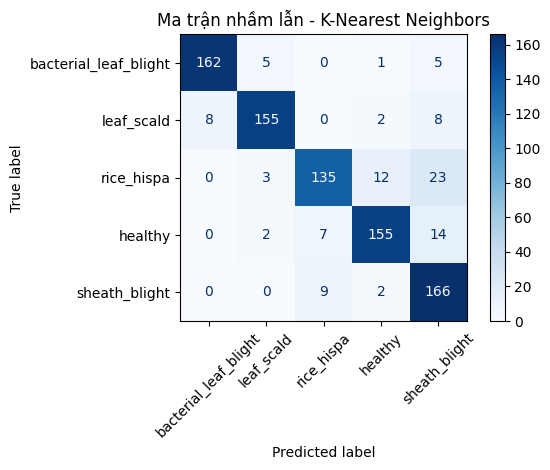

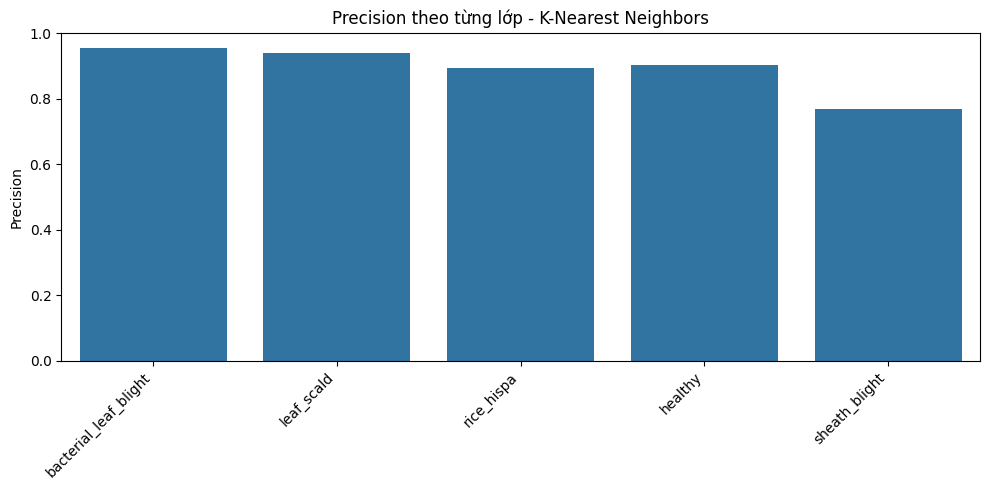

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier # Import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

DATA_DIR = "/content/drive/MyDrive/Lua_16:4_HOG+Color"


try:
    X_train = np.load(os.path.join(DATA_DIR, 'X_train1.npy'))
    X_val   = np.load(os.path.join(DATA_DIR, 'X_val1.npy'))
    X_test  = np.load(os.path.join(DATA_DIR, 'X_test1.npy'))
    y_train = np.load(os.path.join(DATA_DIR, 'y_train1.npy'))
    y_val   = np.load(os.path.join(DATA_DIR, 'y_val1.npy'))
    y_test  = np.load(os.path.join(DATA_DIR, 'y_test1.npy'))
    print(f"Đã tải dữ liệu từ {DATA_DIR} (X_train1.npy và các file liên quan).")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy các file dữ liệu tại {DATA_DIR}. Vui lòng kiểm tra lại đường dẫn và tên file.")
    exit()

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

# ====== Tổng số lượng mẫu ======
print(f"\nSố lượng mẫu:")
print(f"- Train: {len(X_train)} mẫu")
print(f"- Validation: {len(X_val)} mẫu")
print(f"- Test: {len(X_test)} mẫu")

# ====== In ra số lượng mẫu theo từng lớp ======
def print_class_distribution(y, split_name):
    print(f"\nSố lượng mẫu theo từng lớp trong tập {split_name}:")
    counter = Counter(y)
    # Sắp xếp các nhãn để in ra thứ tự nhất quán
    sorted_labels = sorted(counter.keys())
    for label in sorted_labels:
        count = counter[label]
        class_name = categories[label] if label < len(categories) else f"Lớp {label} (Chưa xác định)"
        print(f"   - {class_name} ({label}): {count} mẫu")

print_class_distribution(y_train, "Train")
print_class_distribution(y_val, "Validation")
print_class_distribution(y_test, "Test")

print("\nĐang huấn luyện mô hình K-Nearest Neighbors...")


knn_model = KNeighborsClassifier(n_neighbors=7, weights='distance', p=2)

knn_model.fit(X_train, y_train)


print("\nĐánh giá mô hình K-Nearest Neighbors trên tập validation...")
y_val_pred_knn = knn_model.predict(X_val)
val_acc_knn = accuracy_score(y_val, y_val_pred_knn)
val_f1_knn = f1_score(y_val, y_val_pred_knn, average='weighted')
print(f"\n[K-Nearest Neighbors] Accuracy (val): {val_acc_knn*100:.2f}%")
print(f"[K-Nearest Neighbors] F1-score (val): {val_f1_knn:.4f}")

print("\nĐánh giá mô hình K-Nearest Neighbors trên tập test...")
y_test_pred_knn = knn_model.predict(X_test)
test_acc_knn = accuracy_score(y_test, y_test_pred_knn)
test_f1_knn = f1_score(y_test, y_test_pred_knn, average='weighted')

print(f"\n[K-Nearest Neighbors] Accuracy (test): {test_acc_knn*100:.2f}%")
print(f"[K-Nearest Neighbors] F1-score (test): {test_f1_knn:.4f}")
print("\n[K-Nearest Neighbors] Báo cáo phân loại:")
print(classification_report(y_test, y_test_pred_knn, target_names=categories))

cm_knn = confusion_matrix(y_test, y_test_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=categories)
disp_knn.plot(cmap="Blues", xticks_rotation=45) # Sử dụng màu xanh cho KNN
plt.title("Ma trận nhầm lẫn - K-Nearest Neighbors")
plt.tight_layout()
plt.show()

# ====== Precision theo lớp cho K-Nearest Neighbors ======
report_knn = classification_report(y_test, y_test_pred_knn, target_names=categories, output_dict=True)
precision_values_knn = []
# Đảm bảo các lớp tồn tại trong report trước khi truy cập
for cat in categories:
    if cat in report_knn and 'precision' in report_knn[cat]:
        precision_values_knn.append(report_knn[cat]['precision'])
    else:
        precision_values_knn.append(0.0) # Gán 0 nếu không tìm thấy (trường hợp hiếm)

if precision_values_knn: # Chỉ vẽ nếu có dữ liệu precision
    plt.figure(figsize=(10, 5))
    sns.barplot(x=categories, y=precision_values_knn)
    plt.ylabel("Precision")
    plt.title("Precision theo từng lớp - K-Nearest Neighbors")
    plt.xticks(rotation=45, ha='right') # Thêm ha='right' để căn chỉnh nhãn
    plt.tight_layout()
    plt.show()
else:
    print("Cảnh báo: Không thể vẽ biểu đồ Precision cho KNN do dữ liệu Precision không hợp lệ.")

Đã tải dữ liệu từ /content/drive/MyDrive/Lua_2 (X_train1.npy và các file liên quan).

Số lượng mẫu:
- Train: 34940 mẫu
- Validation: 874 mẫu
- Test: 874 mẫu

Số lượng mẫu theo từng lớp trong tập Train:
   - bacterial_leaf_blight (0): 6930 mẫu
   - leaf_scald (1): 6915 mẫu
   - rice_hispa (2): 6915 mẫu
   - healthy (3): 7125 mẫu
   - sheath_blight (4): 7055 mẫu

Số lượng mẫu theo từng lớp trong tập Validation:
   - bacterial_leaf_blight (0): 174 mẫu
   - leaf_scald (1): 173 mẫu
   - rice_hispa (2): 173 mẫu
   - healthy (3): 178 mẫu
   - sheath_blight (4): 176 mẫu

Số lượng mẫu theo từng lớp trong tập Test:
   - bacterial_leaf_blight (0): 173 mẫu
   - leaf_scald (1): 173 mẫu
   - rice_hispa (2): 173 mẫu
   - healthy (3): 178 mẫu
   - sheath_blight (4): 177 mẫu

Đang huấn luyện mô hình Hồi quy Logistic...

Đánh giá mô hình Hồi quy Logistic trên tập validation...

[Logistic Regression] Accuracy (val): 81.12%
[Logistic Regression] F1-score (val): 0.8139

Đánh giá mô hình Hồi quy Logistic tr

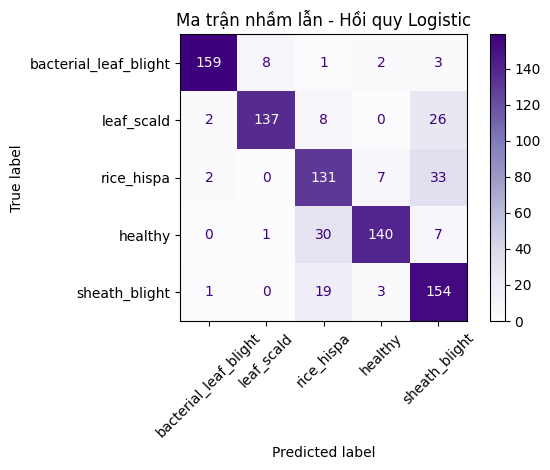

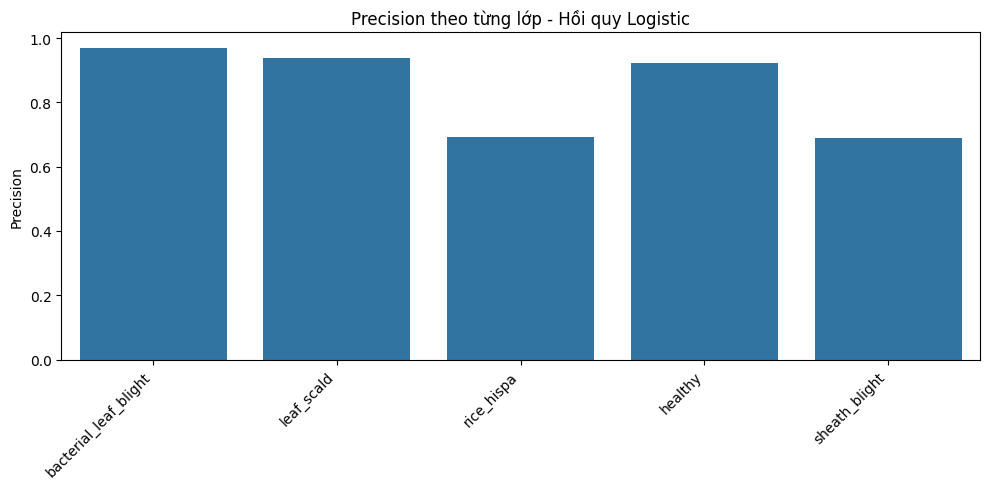

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

DATA_DIR = "/content/drive/MyDrive/Lua_16:4_HOG+Color"
try:
    X_train = np.load(os.path.join(DATA_DIR, 'X_train1.npy'))
    X_val   = np.load(os.path.join(DATA_DIR, 'X_val1.npy'))
    X_test  = np.load(os.path.join(DATA_DIR, 'X_test1.npy'))
    y_train = np.load(os.path.join(DATA_DIR, 'y_train1.npy'))
    y_val   = np.load(os.path.join(DATA_DIR, 'y_val1.npy'))
    y_test  = np.load(os.path.join(DATA_DIR, 'y_test1.npy'))
    print(f"Đã tải dữ liệu từ {DATA_DIR} (X_train1.npy và các file liên quan).")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy các file dữ liệu tại {DATA_DIR}. Vui lòng kiểm tra lại đường dẫn và tên file.")
    exit()

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

# ====== Tổng số lượng mẫu ======
print(f"\nSố lượng mẫu:")
print(f"- Train: {len(X_train)} mẫu")
print(f"- Validation: {len(X_val)} mẫu")
print(f"- Test: {len(X_test)} mẫu")

# ====== In ra số lượng mẫu theo từng lớp ======
def print_class_distribution(y, split_name):
    print(f"\nSố lượng mẫu theo từng lớp trong tập {split_name}:")
    counter = Counter(y)
    # Sắp xếp các nhãn để in ra thứ tự nhất quán
    sorted_labels = sorted(counter.keys())
    for label in sorted_labels:
        count = counter[label]
        class_name = categories[label] if label < len(categories) else f"Lớp {label} (Chưa xác định)"
        print(f"   - {class_name} ({label}): {count} mẫu")

print_class_distribution(y_train, "Train")
print_class_distribution(y_val, "Validation")
print_class_distribution(y_test, "Test")

print("\nĐang huấn luyện mô hình Hồi quy Logistic...")


logistic_model = LogisticRegression(C=0.1, solver='liblinear', max_iter=200, random_state=42)

logistic_model.fit(X_train, y_train)

print("\nĐánh giá mô hình Hồi quy Logistic trên tập validation...")
y_val_pred_lr = logistic_model.predict(X_val)
val_acc_lr = accuracy_score(y_val, y_val_pred_lr)
val_f1_lr = f1_score(y_val, y_val_pred_lr, average='weighted')
print(f"\n[Logistic Regression] Accuracy (val): {val_acc_lr*100:.2f}%")
print(f"[Logistic Regression] F1-score (val): {val_f1_lr:.4f}")

print("\nĐánh giá mô hình Hồi quy Logistic trên tập test...")
y_test_pred_lr = logistic_model.predict(X_test)
test_acc_lr = accuracy_score(y_test, y_test_pred_lr)
test_f1_lr = f1_score(y_test, y_test_pred_lr, average='weighted')

print(f"\n[Logistic Regression] Accuracy (test): {test_acc_lr*100:.2f}%")
print(f"[Logistic Regression] F1-score (test): {test_f1_lr:.4f}")
print("\n[Logistic Regression] Báo cáo phân loại:")
print(classification_report(y_test, y_test_pred_lr, target_names=categories))

cm_lr = confusion_matrix(y_test, y_test_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=categories)
disp_lr.plot(cmap="Purples", xticks_rotation=45) # Sử dụng màu tím cho Logistic Regression
plt.title("Ma trận nhầm lẫn - Hồi quy Logistic")
plt.tight_layout()
plt.show()

report_lr = classification_report(y_test, y_test_pred_lr, target_names=categories, output_dict=True)
precision_values_lr = []
# Đảm bảo các lớp tồn tại trong report trước khi truy cập
for cat in categories:
    if cat in report_lr and 'precision' in report_lr[cat]:
        precision_values_lr.append(report_lr[cat]['precision'])
    else:
        precision_values_lr.append(0.0) # Gán 0 nếu không tìm thấy (trường hợp hiếm)

if precision_values_lr: # Chỉ vẽ nếu có dữ liệu precision
    plt.figure(figsize=(10, 5))
    sns.barplot(x=categories, y=precision_values_lr)
    plt.ylabel("Precision")
    plt.title("Precision theo từng lớp - Hồi quy Logistic")
    plt.xticks(rotation=45, ha='right') # Thêm ha='right' để căn chỉnh nhãn
    plt.tight_layout()
    plt.show()
else:
    print("Cảnh báo: Không thể vẽ biểu đồ Precision cho Hồi quy Logistic do dữ liệu Precision không hợp lệ.")

In [ ]:
import numpy as np
import os
import joblib # Để lưu và tải mô hình
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from itertools import product

# ====== Cấu hình đường dẫn ======
DATA_DIR = '/content/drive/MyDrive/Lua_16:4_HOG+Color'

# ====== Tải dữ liệu ======
try:
    X_train = np.load(os.path.join(DATA_DIR, 'X_train1.npy'))
    X_val   = np.load(os.path.join(DATA_DIR, 'X_val1.npy'))
    y_train = np.load(os.path.join(DATA_DIR, 'y_train1.npy'))
    y_val   = np.load(os.path.join(DATA_DIR, 'y_val1.npy'))
    print("Đã tải dữ liệu thành công!")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy tệp dữ liệu trong thư mục '{DATA_DIR}'.")
    exit()

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

best_score = -1
best_params = {}
results = []

param_grid = {
    'C': [0.1, 10, 20, 50],
    'kernel': ['rbf'],
    'gamma': ['scale', 0.01, 0.001]
}

all_param_combinations = list(product(param_grid['C'], param_grid['kernel'], param_grid['gamma']))

try:
    with open('/content/drive/MyDrive/svm_search_results.pkl', 'rb') as f:
        results = joblib.load(f)
    print(f"Đã tải {len(results)} kết quả đã huấn luyện trước đó.")

    # --- HIỂN THỊ ĐỘ CHÍNH XÁC CỦA TỪNG LẦN HUẤN LUYỆN ĐÃ TẢI ---
    if results:
        print("\n--- Chi tiết các kết quả đã huấn luyện trước đó ---")
        for i, res in enumerate(results):
            # Kiểm tra xem các khóa có tồn tại không trước khi truy cập
            c_val = res.get('C', 'N/A')
            kernel_val = res.get('kernel', 'N/A')
            gamma_val = res.get('gamma', 'N/A')
            score_val = res.get('score', 'N/A')
            print(f"  Lần {i+1}: C={c_val}, kernel={kernel_val}, gamma={gamma_val}, Score: {score_val:.4f}")

        # Cập nhật best_score và best_params từ dữ liệu đã lưu
        current_best_result = max(results, key=lambda x: x['score'])
        best_score = current_best_result['score']
        best_params = {k: current_best_result[k] for k in ['C', 'kernel', 'gamma'] if k in current_best_result}
        print(f"\nCập nhật best_score từ dữ liệu đã lưu: {best_score:.4f}")
        print(f"Cập nhật best_params từ dữ liệu đã lưu: {best_params}")

except FileNotFoundError:
    print("Không tìm thấy kết quả đã lưu, bắt đầu từ đầu.")

trained_combinations = [(res['C'], res['kernel'], res['gamma']) for res in results]

for C_val, kernel_val, gamma_val in all_param_combinations:
    if (C_val, kernel_val, gamma_val) in trained_combinations:
        print(f"Đã huấn luyện với C={C_val}, kernel={kernel_val}, gamma={gamma_val}. Bỏ qua.")
        continue

    print(f"Huấn luyện với C={C_val}, kernel={kernel_val}, gamma={gamma_val}")
    svm_model = SVC(C=C_val, kernel=kernel_val, gamma=gamma_val)
    svm_model.fit(X_train, y_train)

    y_pred_val = svm_model.predict(X_val)
    score = accuracy_score(y_val, y_pred_val)
    print(f"Độ chính xác trên tập validation: {score:.4f}")

    results.append({
        'C': C_val,
        'kernel': kernel_val,
        'gamma': gamma_val,
        'score': score
    })

    # Lưu lại kết quả sau mỗi lần huấn luyện
    with open('/content/drive/MyDrive/svm_search_results.pkl', 'wb') as f:
        joblib.dump(results, f)
    print("Đã lưu tiến độ.")

    if score > best_score:
        best_score = score
        best_params = {'C': C_val, 'kernel': kernel_val, 'gamma': gamma_val}
        # Tùy chọn: lưu mô hình tốt nhất hiện tại
        joblib.dump(svm_model, '/content/drive/MyDrive/best_svm_model.pkl')
        print(f"Đã lưu mô hình tốt nhất với độ chính xác: {best_score:.4f}")

print("\n--- Hoàn tất tìm kiếm tham số ---")
print("Best params found:", best_params)
print(f"Best validation score: {best_score:.4f}")


Đã tải dữ liệu thành công!
Đã tải 9 kết quả đã huấn luyện trước đó.

--- Chi tiết các kết quả đã huấn luyện trước đó ---
  Lần 1: C=0.1, kernel=rbf, gamma=scale, Score: 0.7963
  Lần 2: C=0.1, kernel=rbf, gamma=0.01, Score: 0.7792
  Lần 3: C=0.1, kernel=rbf, gamma=0.001, Score: 0.7014
  Lần 4: C=10, kernel=rbf, gamma=scale, Score: 0.9314
  Lần 5: C=10, kernel=rbf, gamma=0.01, Score: 0.9073
  Lần 6: C=10, kernel=rbf, gamma=0.001, Score: 0.8238
  Lần 7: C=20, kernel=rbf, gamma=scale, Score: 0.9314
  Lần 8: C=20, kernel=rbf, gamma=0.01, Score: 0.9233
  Lần 9: C=20, kernel=rbf, gamma=0.001, Score: 0.8421

Cập nhật best_score từ dữ liệu đã lưu: 0.9314
Cập nhật best_params từ dữ liệu đã lưu: {'C': 10, 'kernel': 'rbf', 'gamma': 'scale'}
Đã huấn luyện với C=0.1, kernel=rbf, gamma=scale. Bỏ qua.
Đã huấn luyện với C=0.1, kernel=rbf, gamma=0.01. Bỏ qua.
Đã huấn luyện với C=0.1, kernel=rbf, gamma=0.001. Bỏ qua.
Đã huấn luyện với C=10, kernel=rbf, gamma=scale. Bỏ qua.
Đã huấn luyện với C=10, kernel=

In [ ]:

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]


def extract_color_histogram(image, bins=(8, 8, 8)):
    # Chuyển đổi ảnh sang không gian màu HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Tính toán histogram cho từng kênh màu H, S, V
    hist_h = cv2.calcHist([hsv_image], [0], None, [bins[0]], [0, 180])
    hist_s = cv2.calcHist([hsv_image], [1], None, [bins[1]], [0, 256])
    hist_v = cv2.calcHist([hsv_image], [2], None, [bins[2]], [0, 256])

    # Chuẩn hóa và nối các histogram lại
    hist_h = cv2.normalize(hist_h, hist_h).flatten()
    hist_s = cv2.normalize(hist_s, hist_s).flatten()
    hist_v = cv2.normalize(hist_v, hist_v).flatten()

    # Kết hợp các histogram lại thành một vector đặc trưng duy nhất
    return np.concatenate((hist_h, hist_s, hist_v))

def preprocess_and_extract_features(image_path, scaler):

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Không tìm thấy file: {image_path}")

    # Đọc ảnh màu (quan trọng để trích xuất histogram màu)
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Lỗi khi đọc ảnh (cv2.imread trả về None): {image_path}")

    # Thay đổi kích thước ảnh về 128x128
    img = cv2.resize(img, (128, 128))

    # Chuyển ảnh sang ảnh xám để tính HOG
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Trích xuất đặc trưng HOG
    hog_feature = hog(
        gray,
        pixels_per_cell=(16, 16),
        cells_per_block=(4, 4),
        block_norm='L1-sqrt',
        feature_vector=True
    )

    # Trích xuất đặc trưng Histogram màu
    color_hist_feature = extract_color_histogram(img) # Truyền ảnh màu vào

    # Kết hợp đặc trưng HOG và Histogram màu
    combined_features = np.concatenate((hog_feature, color_hist_feature))

    # Chuẩn hóa vector đặc trưng kết hợp
    # scaler.transform cần một mảng 2D, ngay cả khi chỉ có 1 mẫu
    scaled_features = scaler.transform([combined_features])

    # Trả về mảng 1D của đặc trưng đã chuẩn hóa và đường dẫn ảnh
    return scaled_features[0], image_path

def predict_batch_images(image_folder, model, scaler):
    if not os.path.isdir(image_folder):
        raise NotADirectoryError(f"Đường dẫn không phải là thư mục: {image_folder}")

    predictions_results = []
    supported_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

    print(f"Bắt đầu dự đoán hàng loạt ảnh trong thư mục: {image_folder}\n")

    for filename in os.listdir(image_folder):
        # Lọc các file ảnh theo định dạng
        if filename.lower().endswith(supported_extensions):
            image_path = os.path.join(image_folder, filename)
            try:
                # Tiền xử lý và trích xuất đặc trưng cho từng ảnh
                # Hàm này giờ trả về đặc trưng kết hợp và đã được chuẩn hóa
                features, processed_path = preprocess_and_extract_features(image_path, scaler)

                # Dự đoán nhãn lớp
                # model.predict() vẫn cần một mảng 2D, vì vậy ta truyền [features]
                prediction_label_index = model.predict([features])[0]
                predicted_class_name = categories[prediction_label_index]

                predictions_results.append((processed_path, prediction_label_index, predicted_class_name))
                print(f"Ảnh '{filename}' -> Dự đoán: {predicted_class_name}")

            except (FileNotFoundError, ValueError, Exception) as e:
                print(f"Lỗi khi xử lý ảnh '{filename}': {e}")
                predictions_results.append((image_path, -1, f"Lỗi: {e}")) # Ghi lại lỗi
    return predictions_results

model_path = "/content/drive/MyDrive/Lua_16:4_HOG+Color/svm_model_best.pkl"
scaler_path = "/content/drive/MyDrive/Lua_16:4_HOG+Color/scaler1.pkl"

# Kiểm tra sự tồn tại của file model và scaler
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Không tìm thấy mô hình: {model_path}")
if not os.path.exists(scaler_path):
    raise FileNotFoundError(f"Không tìm thấy scaler: {scaler_path}")

# Tải model và scaler
svm_model = joblib.load(model_path)
scaler = joblib.load(scaler_path)

# Đường dẫn đến thư mục chứa ảnh cần dự đoán
test_image_folder = "/content/drive/MyDrive/DATASET/Test_Model"

# Gọi hàm dự đoán hàng loạt
all_predictions = predict_batch_images(test_image_folder, svm_model, scaler)

Bắt đầu dự đoán hàng loạt ảnh trong thư mục: /content/drive/MyDrive/DATASET/Test_Model

Ảnh 'healthy2.jpg' -> Dự đoán: healthy
Ảnh 'healthy1.jpg' -> Dự đoán: healthy
Ảnh 'rice_hispa1.jpg' -> Dự đoán: rice_hispa
Ảnh 'rice_hispa2.jpg' -> Dự đoán: rice_hispa
Ảnh 'sheath_blight1.jpg' -> Dự đoán: sheath_blight
Ảnh 'sheath_blight2.jpg' -> Dự đoán: sheath_blight
Ảnh 'leaf scald2.png' -> Dự đoán: rice_hispa
Ảnh 'bacterial_leaf_blight 1.png' -> Dự đoán: bacterial_leaf_blight


In [ ]:

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

def extract_color_histogram(image, bins=(8, 8, 8)):


    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)


    hist_h = cv2.calcHist([hsv_image], [0], None, [bins[0]], [0, 180])
    hist_s = cv2.calcHist([hsv_image], [1], None, [bins[1]], [0, 256])
    hist_v = cv2.calcHist([hsv_image], [2], None, [bins[2]], [0, 256])

    # Chuẩn hóa và nối các histogram lại
    hist_h = cv2.normalize(hist_h, hist_h).flatten()
    hist_s = cv2.normalize(hist_s, hist_s).flatten()
    hist_v = cv2.normalize(hist_v, hist_v).flatten()

    # Kết hợp các histogram lại thành một vector đặc trưng duy nhất
    return np.concatenate((hist_h, hist_s, hist_v))

def preprocess_and_extract_features(image_path, scaler):

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Không tìm thấy file: {image_path}")

    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Lỗi khi đọc ảnh (cv2.imread trả về None): {image_path}")

    # Thay đổi kích thước ảnh về 128x128
    img = cv2.resize(img, (128, 128))

    # --- CHỈ TRÍCH XUẤT ĐẶC TRƯNG COLOR HISTOGRAM ---
    color_hist_feature = extract_color_histogram(img)

    # Chuẩn hóa vector đặc trưng (chỉ có Color Histogram)
    # scaler.transform cần một mảng 2D, ngay cả khi chỉ có 1 mẫu
    scaled_features = scaler.transform([color_hist_feature])

    # Trả về mảng 1D của đặc trưng đã chuẩn hóa và đường dẫn ảnh
    return scaled_features[0], image_path

def predict_batch_images(image_folder, model, scaler):

    if not os.path.isdir(image_folder):
        raise NotADirectoryError(f"Đường dẫn không phải là thư mục: {image_folder}")

    predictions_results = []
    supported_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

    print(f"Bắt đầu dự đoán hàng loạt ảnh trong thư mục: {image_folder}\n")

    for filename in os.listdir(image_folder):
        # Lọc các file ảnh theo định dạng
        if filename.lower().endswith(supported_extensions):
            image_path = os.path.join(image_folder, filename)
            try:
                # Tiền xử lý và trích xuất đặc trưng (chỉ Color Histogram)
                features, processed_path = preprocess_and_extract_features(image_path, scaler)

                # Dự đoán nhãn lớp
                # model.predict() vẫn cần một mảng 2D, vì vậy ta truyền [features]
                prediction_label_index = model.predict([features])[0]
                predicted_class_name = categories[prediction_label_index]

                predictions_results.append((processed_path, prediction_label_index, predicted_class_name))
                print(f"Ảnh '{filename}' -> Dự đoán: {predicted_class_name}")

            except (FileNotFoundError, ValueError, Exception) as e:
                print(f"Lỗi khi xử lý ảnh '{filename}': {e}")
                predictions_results.append((image_path, -1, f"Lỗi: {e}")) # Ghi lại lỗi
    return predictions_results
model_path = "/content/drive/MyDrive/Lua_16:4_Color/svm_model_100.pkl"
scaler_path = "/content/drive/MyDrive/Lua_16:4_Color/scaler2.pkl"

# Kiểm tra sự tồn tại của file model và scaler
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Không tìm thấy mô hình: {model_path}. Vui lòng kiểm tra lại đường dẫn.")
if not os.path.exists(scaler_path):
    raise FileNotFoundError(f"Không tìm thấy scaler: {scaler_path}. Vui lòng kiểm tra lại đường dẫn.")

# Tải model và scaler
print(f"Đang tải mô hình từ: {model_path}")
svm_model = joblib.load(model_path)
print(f"Đang tải scaler từ: {scaler_path}")
scaler = joblib.load(scaler_path)
print("Đã tải mô hình và scaler thành công.")

# Đường dẫn đến thư mục chứa ảnh cần dự đoán
test_image_folder = "/content/drive/MyDrive/DATASET/Test_Model"
print(f"Đang chuẩn bị dự đoán ảnh trong thư mục: {test_image_folder}")

# Gọi hàm dự đoán hàng loạt
all_predictions = predict_batch_images(test_image_folder, svm_model, scaler)

Đang tải mô hình từ: /content/drive/MyDrive/Lua_16:4_Color/svm_model_100.pkl
Đang tải scaler từ: /content/drive/MyDrive/Lua_16:4_Color/scaler2.pkl
Đã tải mô hình và scaler thành công.
Đang chuẩn bị dự đoán ảnh trong thư mục: /content/drive/MyDrive/DATASET/Test_Model
Bắt đầu dự đoán hàng loạt ảnh trong thư mục: /content/drive/MyDrive/DATASET/Test_Model

Ảnh 'healthy2.jpg' -> Dự đoán: healthy
Ảnh 'healthy1.jpg' -> Dự đoán: healthy
Ảnh 'rice_hispa1.jpg' -> Dự đoán: rice_hispa
Ảnh 'rice_hispa2.jpg' -> Dự đoán: rice_hispa
Ảnh 'sheath_blight1.jpg' -> Dự đoán: sheath_blight
Ảnh 'sheath_blight2.jpg' -> Dự đoán: sheath_blight
Ảnh 'leaf scald2.png' -> Dự đoán: bacterial_leaf_blight
Ảnh 'bacterial_leaf_blight 1.png' -> Dự đoán: bacterial_leaf_blight
